# Real-world scenario in computational finance:
# option pricing, volatility, principal component analysis,  
# value at risk, expected shortfall, model validation

The project is based on the Tesla and Boeing stock prices data from within one year long time period and the Tesla option chain from within the same time period. The data is downloaded from Yahoo Finance (YF).

The project consists of the following parts.  
1. Stock data and options chain load with initial formatting, analysis and visualization.
2. Introduction of the Black-Scholes-Merton (BSM) model for a non-dividend paying stock with determination of its parameters, i.e. the spot price and risk-free interest rate.
3. Volatility smiles for selected Tesla options' expiry dates & volatility surfaces.
4. The BSM option prices for the Tesla stocks using historical volatility - comparison with the YF data.
5. Implied volatility for the Tesla options using the Brent's method - comparison with the YF data.
6. The BSM option prices for the Tesla stocks using the calculated implied volatility - comparison with the YF data.
7. Principal component analysis (PCA) in volatility modelling & option pricing.
8. Martingales in the Monte-Carlo option pricing for the Tesla stocks.
9. Value at risk (VaR) and expected shortfall (ES) calculations for a two-asset portfolio with the use of the historical, variance-covariance (parametric) and Monte-Carlo methods.
10. Model validation of the VaR calculations for a two-asset portfolio using ANOVA, backtesting via Kupiec & Christoffersen tests, ES analysis and stress testing.

---------------------------------

The project allows to analyze either current financial data, from within last year, or a predefined set, which consists of data from within the period 01/03/2024 to 28/02/2025.

---------------------------------

Parameter/variable values that can be adjusted/selected according to one's computational needs are marked by a set of hashes at the end of a corresponding explanation line.

In [3]:
period = input("Would you like to analyze current (C) or predefined data (P)? ")
print(period)

Would you like to analyze current (C) or predefined data (P)?  P


P


In [4]:
# installing the library that provides access to financial data on Yahoo Finance
!pip install yfinance

#### Libraries import

In [6]:
import yfinance as yf

import requests
from bs4 import BeautifulSoup

import pandas as pd
pd.options.mode.chained_assignment = None   # disable warning on chain assignments

import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
plt.rcParams['axes.grid'] = True
import matplotlib.dates as mdates
import matplotlib.colors
from matplotlib.colors import TwoSlopeNorm
from matplotlib.pyplot import figure

import datetime as dt

from scipy.optimize import brentq
from scipy.optimize import minimize

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

from tabulate import tabulate

from sklearn.decomposition import PCA

from IPython.core.magic import register_cell_magic
from IPython import get_ipython
#
@register_cell_magic
def skip_if(line, cell):   # conditionally skip cell execution
    if eval(line):
        return
    get_ipython().run_cell(cell)

import warnings
warnings.filterwarnings('ignore')   # suppress warnings

#### 1. Stock data load

In [8]:
%%skip_if (period == 'P')

Tesla_data = yf.Ticker('TSLA')
Boeing_data = yf.Ticker('BA')

In [9]:
%%skip_if (period == 'P')
# Tesla & Boeing stock prices from within the last year
stockdata = Tesla_data.history(period = '1y', actions = False)
stockdata_BA = Boeing_data.history(period = '1y', actions = False)

# save data to file
#stockdata.to_csv("TSLA.csv")
#stockdata_BA.to_csv("BA.csv")

# date shift from the day of predefined data load in days
date_shift = 0

In [10]:
%%skip_if (period == 'C')
# read data from file
stockdata = pd.read_csv("TSLA.csv")
stockdata.set_index('Date', inplace = True)
stockdata.index = pd.to_datetime(stockdata.index, utc = True)
#
stockdata_BA = pd.read_csv("BA.csv")
stockdata_BA.set_index('Date', inplace = True)
stockdata_BA.index = pd.to_datetime(stockdata.index, utc = True)

# calculating date shift from the day of predefined data load in days
predefined_data_load = dt.datetime.strptime('01/03/2025', "%d/%m/%Y")
today = dt.datetime.today()
#
date_shift = (today - predefined_data_load).days

In [11]:
stockdata

,Open,High,Low,Close,Volume
Date,,,,,
2024-03-01 05:00:00+00:00,200.520004,204.520004,198.500000,202.639999,82099200
2024-03-04 05:00:00+00:00,198.729996,199.750000,186.720001,188.139999,134334900
2024-03-05 05:00:00+00:00,183.050003,184.589996,177.570007,180.740005,119660800
2024-03-06 05:00:00+00:00,179.990005,181.580002,173.699997,176.539993,107920900
2024-03-07 05:00:00+00:00,174.350006,180.039993,173.699997,178.649994,102129000
...,...,...,...,...,...
2025-02-24 05:00:00+00:00,338.140015,342.399994,324.700012,330.529999,76052300
2025-02-25 05:00:00+00:00,327.019989,328.890015,297.250000,302.799988,134228800
2025-02-26 05:00:00+00:00,303.709991,309.000000,288.040009,290.799988,100118300


In [12]:
stockdata.index

DatetimeIndex(['2024-03-01 05:00:00+00:00', '2024-03-04 05:00:00+00:00',
               '2024-03-05 05:00:00+00:00', '2024-03-06 05:00:00+00:00',
               '2024-03-07 05:00:00+00:00', '2024-03-08 05:00:00+00:00',
               '2024-03-11 04:00:00+00:00', '2024-03-12 04:00:00+00:00',
               '2024-03-13 04:00:00+00:00', '2024-03-14 04:00:00+00:00',
               ...
               '2025-02-14 05:00:00+00:00', '2025-02-18 05:00:00+00:00',
               '2025-02-19 05:00:00+00:00', '2025-02-20 05:00:00+00:00',
               '2025-02-21 05:00:00+00:00', '2025-02-24 05:00:00+00:00',
               '2025-02-25 05:00:00+00:00', '2025-02-26 05:00:00+00:00',
               '2025-02-27 05:00:00+00:00', '2025-02-28 05:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Date', length=250, freq=None)

In [13]:
# dataframe index formatting
stockdata.index = stockdata.index.strftime('%d/%m/%Y')
stockdata_BA.index = stockdata_BA.index.strftime('%d/%m/%Y')

stockdata.head()

,Open,High,Low,Close,Volume
Date,,,,,
01/03/2024,200.520004,204.520004,198.500000,202.639999,82099200
04/03/2024,198.729996,199.750000,186.720001,188.139999,134334900
05/03/2024,183.050003,184.589996,177.570007,180.740005,119660800
06/03/2024,179.990005,181.580002,173.699997,176.539993,107920900
07/03/2024,174.350006,180.039993,173.699997,178.649994,102129000


In [14]:
stockdata.reset_index(inplace = True)
stockdata_BA.reset_index(inplace = True)

stockdata.head()

,Date,Open,High,Low,Close,Volume
0,01/03/2024,200.520004,204.520004,198.500000,202.639999,82099200
1,04/03/2024,198.729996,199.750000,186.720001,188.139999,134334900
2,05/03/2024,183.050003,184.589996,177.570007,180.740005,119660800
3,06/03/2024,179.990005,181.580002,173.699997,176.539993,107920900
4,07/03/2024,174.350006,180.039993,173.699997,178.649994,102129000


In [15]:
# checking whether there are any missing values in the dataframe
stockdata.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [16]:
stockdata_BA.isnull().sum()

Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [17]:
stockdata.shape

(250, 6)

In [18]:
trading_days = stockdata.shape[0]
trading_days

250

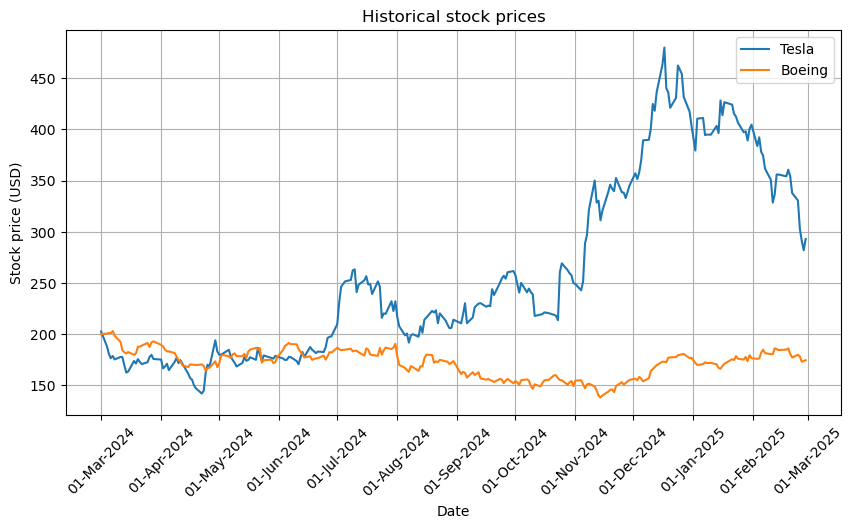

In [19]:
# plotting the Tesla & Boeing stock prices
plt.figure(figsize = (10,5))
plt.title("Historical stock prices")
plt.xlabel("Date")
plt.ylabel("Stock price (USD)")

x = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in stockdata['Date']]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.plot(x, stockdata['Close'], label = "Tesla")
plt.plot(x, stockdata_BA['Close'], label = "Boeing")

plt.legend()
plt.xticks(rotation = 45)
plt.grid(True)

#### Options data load

In [21]:
%%skip_if (period == 'P')
# getting the list of expirations
exp = list(Tesla_data.options)

# save data to file
#with open ("exp.csv", 'w') as new:
#    new.write(str(exp))

In [22]:
%%skip_if (period == 'C')
# read data from file
with open ("exp.csv", 'r') as file:
    exp = file.read()
exp = exp.translate({ord(i): None for i in "[]'"})
exp = exp.split(", ")

In [23]:
exp

['2025-03-07',
 '2025-03-14',
 '2025-03-21',
 '2025-03-28',
 '2025-04-04',
 '2025-04-17',
 '2025-05-16',
 '2025-06-20',
 '2025-07-18',
 '2025-08-15',
 '2025-09-19',
 '2025-11-21',
 '2025-12-19',
 '2026-01-16',
 '2026-03-20',
 '2026-06-18',
 '2026-09-18',
 '2026-12-18',
 '2027-01-15',
 '2027-06-17']

In [24]:
# selection of expiration dates #####################################
i_exp = 3
i_exp_far = -5
#
exp_date = exp[i_exp]
exp_date_far = exp[i_exp_far]

In [25]:
%%skip_if (period == 'P')
# downloading option chains for selected expiration dates
opt = Tesla_data.option_chain(date = exp_date)
opt_far = Tesla_data.option_chain(date = exp_date_far)

# creating dataframes that contain data on calls and puts
calls_opt = opt.calls.drop('contractSymbol', axis = 1)
puts_opt = opt.puts.drop('contractSymbol', axis = 1)
#
calls_opt_far = opt_far.calls.drop('contractSymbol', axis = 1)
puts_opt_far = opt_far.puts.drop('contractSymbol', axis = 1)

# save data to file
#calls_opt.to_csv("TSLA_calls_opt.csv")
#puts_opt.to_csv("TSLA_puts_opt.csv")
#calls_opt_far.to_csv("TSLA_calls_opt_far.csv")
#puts_opt_far.to_csv("TSLA_puts_opt_far.csv")

In [26]:
%%skip_if (period == 'C')
# read data from file
calls_opt = pd.read_csv("TSLA_calls_opt.csv")
calls_opt.drop('Unnamed: 0', axis = 1, inplace = True)
puts_opt = pd.read_csv("TSLA_puts_opt.csv")
puts_opt.drop('Unnamed: 0', axis = 1, inplace = True)
calls_opt_far = pd.read_csv("TSLA_calls_opt_far.csv")
calls_opt_far.drop('Unnamed: 0', axis = 1, inplace = True)
puts_opt_far = pd.read_csv("TSLA_puts_opt_far.csv")
puts_opt_far.drop('Unnamed: 0', axis = 1, inplace = True)

In [27]:
calls_opt['expiration'] = pd.to_datetime(exp_date)
calls_opt['daysToExpiration'] = (calls_opt['expiration'] - dt.datetime.today()).dt.days + 1 + date_shift
puts_opt['expiration'] = pd.to_datetime(exp_date)
puts_opt['daysToExpiration'] = (puts_opt['expiration'] - dt.datetime.today()).dt.days + 1 + date_shift
#
calls_opt_far['expiration'] = pd.to_datetime(exp_date_far)
calls_opt_far['daysToExpiration'] = (calls_opt_far['expiration'] - dt.datetime.today()).dt.days + 1 + date_shift
puts_opt_far['expiration'] = pd.to_datetime(exp_date_far)
puts_opt_far['daysToExpiration'] = (puts_opt_far['expiration'] - dt.datetime.today()).dt.days + 1 + date_shift

In [28]:
calls_opt.head()

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,expiration,daysToExpiration
0,2025-02-27 16:24:15+00:00,100.0,191.20,191.70,195.55,0.00,0.000000,2,55,1.891602,True,REGULAR,USD,2025-03-28,27
1,2025-02-21 18:11:56+00:00,150.0,188.45,142.35,146.10,0.00,0.000000,1,1,1.374027,True,REGULAR,USD,2025-03-28,27
2,2025-02-21 20:36:53+00:00,170.0,167.58,122.50,126.45,0.00,0.000000,1,2,1.189457,True,REGULAR,USD,2025-03-28,27
3,2025-02-25 20:47:11+00:00,190.0,110.33,102.80,106.80,0.00,0.000000,1,12,1.022466,True,REGULAR,USD,2025-03-28,27
4,2025-02-28 20:57:45+00:00,200.0,94.20,93.45,96.80,7.25,8.338126,1004,18,0.957520,True,REGULAR,USD,2025-03-28,27


-------

In [30]:
%%skip_if (period == 'P')
# combining option chains for all expiration dates into one dataframe
def option_chains(asset_data):
    exps = asset_data.options
    chains = pd.DataFrame()

    for e in exps:
        opt = asset_data.option_chain(e)

        calls = opt.calls
        calls['optionType'] = 'call'
        puts = opt.puts
        puts['optionType'] = 'put'
        chain = pd.concat([calls, puts])
        chain['expiration'] = pd.to_datetime(e)

        chains = pd.concat([chains, chain])

    chains['daysToExpiration'] = (chains['expiration'] - dt.datetime.today()).dt.days + 1

    return chains

In [31]:
%%skip_if (period == 'P')
cp_options = option_chains(Tesla_data).drop('contractSymbol', axis = 1)

# save data to file
#cp_options.to_csv("TSLA_cp_options.csv")

In [32]:
%%skip_if (period == 'C')
# read data from file
cp_options = pd.read_csv("TSLA_cp_options.csv")
cp_options.drop('Unnamed: 0', axis = 1, inplace = True)

In [33]:
cp_options['T [years]'] = cp_options['daysToExpiration'] / 365

cp_options.head()

,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expiration,daysToExpiration,T [years]
0,2025-02-28 20:55:28+00:00,100.0,191.46,191.45,194.65,4.010010,2.139242,96.0,41,2.867190,True,REGULAR,USD,call,2025-03-07,6,0.016438
1,2025-02-28 18:00:35+00:00,110.0,174.66,181.20,185.25,-19.539993,-10.061789,2.0,22,3.031252,True,REGULAR,USD,call,2025-03-07,6,0.016438
2,2025-02-25 18:37:00+00:00,120.0,171.24,171.20,175.30,-10.959991,-6.015363,2.0,20,2.812503,True,REGULAR,USD,call,2025-03-07,6,0.016438
3,2025-02-26 18:19:38+00:00,130.0,166.10,161.30,165.30,0.000000,0.000000,1.0,15,2.636722,True,REGULAR,USD,call,2025-03-07,6,0.016438
4,2025-02-27 15:19:26+00:00,140.0,148.19,151.25,155.35,0.000000,0.000000,3.0,50,2.414066,True,REGULAR,USD,call,2025-03-07,6,0.016438


In [34]:
cp_options.shape

(4223, 17)

In [35]:
# option chains for all expiration dates for calls and puts separately
cp_options_calls = cp_options[cp_options['optionType'] == 'call']
cp_options_puts = cp_options[cp_options['optionType'] == 'put']

-------  
-------

### 2. Black-Scholes-Merton (BSM) model for a non-dividend paying stock

In [38]:
class BSMmodel:
    def __init__(self, S0, K, T, σ, r):
        self.S0 = S0
        self.K = K
        self.T = T
        self.σ = σ
        self.r = r

    # calculating the BSM model variables
    def d1(self):
        return (np.log(self.S0/self.K) + (self.r + self.σ**2/2) * self.T) / (self.σ * np.sqrt(self.T))
    
    def d2(self):
        return self.d1() - self.σ * np.sqrt(self.T)
    
    # calculating the European option prices
    def call_price(self):
        return (self.S0 * norm.cdf(self.d1()) - self.K * np.exp(-self.r * self.T) * norm.cdf(self.d2()))
    
    def put_price(self):
        return (self.K * np.exp(-self.r * self.T) * norm.cdf(-self.d2()) - self.S0 * norm.cdf(-self.d1()))

#### Stock price on the last day of the considered period

In [40]:
S0 = round(stockdata.loc[trading_days - 1, 'Close'], 2)
S0

292.98

#### Real risk-free rate calculation

One of the BSM model parameters is the risk-free rate, r. It is a return rate received on hypothetical zero-risk assets, which serves as the minimum yield required on riskier investments. The nominal risk-free rate refers to the required return on a risk-free asset without the effect of inflation, while the real risk-free rate takes the rate of inflation into account. The relation between the two types of risk-free rates is the following: $\textrm{real risk-free rate} = \frac{1 + \textrm{nominal risk-free rate}}{1 + \textrm{inflation rate}} - 1$.

In [43]:
%%skip_if (period == 'P')
# fetching the nominal risk-free rate (using the current 3-month U.S. Treasury Bill (T-bill) yield)
def get_nominal_rfr():
    t_bill = yf.Ticker('^IRX')   # the ticker for the 13-week (3-month) U.S. T-bill rate
    t_bill_data = t_bill.history(period = '1d')
    
    nominal_rate = t_bill_data['Close'].iloc[-1] / 100   # percentage convertion to decimal
    
    return nominal_rate

# webscraping the annual inflation rate as the Personal Consumption Expenditures price index 
# (most recent value from the U.S. Bureau of Economic Analysis) | CPI U.S. BLS inaccessible for scraping
def get_inflation_rate():
    url = 'https://www.bea.gov/data/personal-consumption-expenditures-price-index'
    html_page = requests.get(url).text
    soup = BeautifulSoup(html_page, 'html.parser')
    
    tables = soup.find_all('tbody')
    rows = tables[0].find_all('tr')
    cols = rows[0].find_all('td')
    
    inflation_rate_text = cols[-1].get_text()
    inflation_rate = float(inflation_rate_text.strip().replace('%', '')) / 100   # percentage convertion to decimal
    
    return inflation_rate

# calculating the real risk-free rate
def calc_real_rfr(nominal_rate, inflation_rate):
    real_rfr = (1 + nominal_rate) / (1 + inflation_rate) - 1
    
    return real_rfr

In [44]:
%%skip_if (period == 'P')
nominal_rate = get_nominal_rfr()
inflation_rate = get_inflation_rate()
real_rate = calc_real_rfr(nominal_rate, inflation_rate)
r = round(real_rate, 4)

# save data to file
#with open ("rfr.csv", 'w') as new:
#    new.write(str(r))

In [45]:
%%skip_if (period == 'C')
# read data from file
with open ("rfr.csv", 'r') as file:
    r = float(file.read())

In [46]:
r

0.0165

-------  
-------

### 3. Volatility smile  for selected expiry dates & volatility surface

In [49]:
# filtering out low ivs
calls_opt_fil = calls_opt[calls_opt['impliedVolatility'] >= 0.001]
puts_opt_fil = puts_opt[puts_opt['impliedVolatility'] >= 0.001]
#
calls_opt_far_fil = calls_opt_far[calls_opt_far['impliedVolatility'] >= 0.001]
puts_opt_far_fil = puts_opt_far[puts_opt_far['impliedVolatility'] >= 0.001]

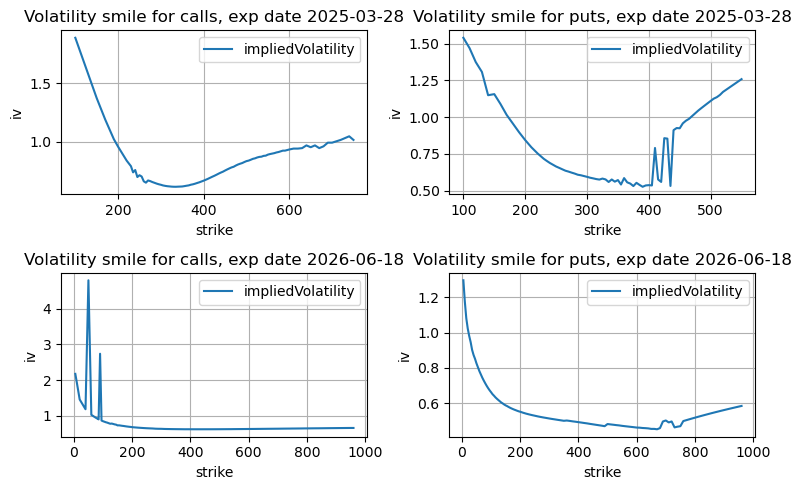

In [50]:
fig, axes = plt.subplots(2, 2, figsize = (8,5))

calls_opt_fil[['strike', 'impliedVolatility']].set_index('strike').plot(ylabel = 'iv', ax = axes[0,0])
puts_opt_fil[['strike', 'impliedVolatility']].set_index('strike').plot(ylabel = 'iv', ax = axes[0,1])
axes[0,0].set_title(f"Volatility smile for calls, exp date {exp_date}")
axes[0,1].set_title(f"Volatility smile for puts, exp date {exp_date}")
#
calls_opt_far_fil[['strike', 'impliedVolatility']].set_index('strike').plot(ylabel = 'iv', ax = axes[1,0])
puts_opt_far_fil[['strike', 'impliedVolatility']].set_index('strike').plot(ylabel = 'iv', ax = axes[1,1])
axes[1,0].set_title(f"Volatility smile for calls, exp date {exp_date_far}")
axes[1,1].set_title(f"Volatility smile for puts, exp date {exp_date_far}")

fig.tight_layout()

-------

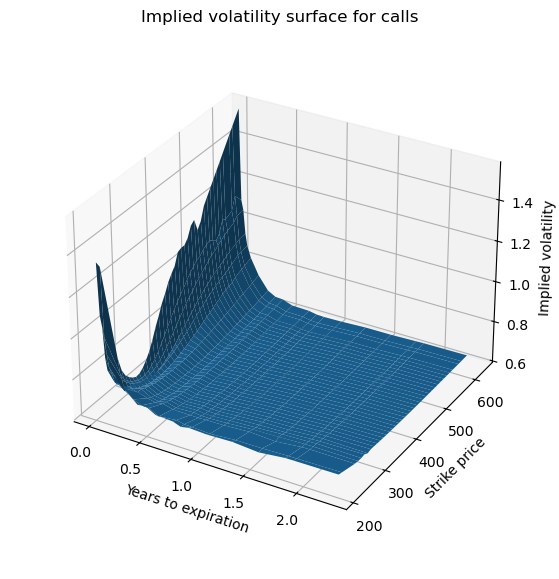

In [52]:
iv_surface_calls = (cp_options_calls[['T [years]', 'strike', 'impliedVolatility']]
                    .pivot_table(values = 'impliedVolatility', index = 'strike', columns = 'T [years]').dropna())

fig = plt.figure(figsize = (9,7))
ax = fig.add_subplot(111, projection = '3d')

x, y, z = iv_surface_calls.columns.values, iv_surface_calls.index.values, iv_surface_calls.values
X, Y = np.meshgrid(x, y)

ax.set_xlabel("Years to expiration")
ax.set_ylabel("Strike price")
ax.set_zlabel("Implied volatility")
ax.set_title("Implied volatility surface for calls")

ax.set_box_aspect(aspect = None, zoom = 0.9)

ax.plot_surface(X, Y, z)

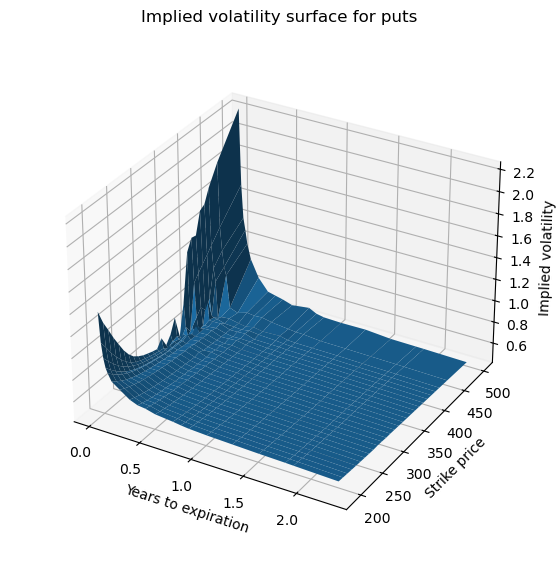

In [53]:
iv_surface_puts = (cp_options_puts[['T [years]', 'strike', 'impliedVolatility']]
                   .pivot_table(values = 'impliedVolatility', index = 'strike', columns = 'T [years]').dropna())

fig = plt.figure(figsize = (9,7))
ax = fig.add_subplot(111, projection = '3d')

x, y, z = iv_surface_puts.columns.values, iv_surface_puts.index.values, iv_surface_puts.values
X, Y = np.meshgrid(x, y)

ax.set_xlabel("Years to expiration")
ax.set_ylabel("Strike price")
ax.set_zlabel("Implied volatility")
ax.set_title("Implied volatility surface for puts")

ax.set_box_aspect(aspect = None, zoom = 0.9)

ax.plot_surface(X, Y, z)

-------

### 4. The BSM option prices for the Tesla stocks using historical volatility - comparison with the YF data

In order to price options for the Tesla stocks, volatility of an underlying asset need to be estimated. Volatility is a measure of uncertainty of the return realized on an asset. It can be interpreted as a standard deviation of the change in stock price in one year. Historical volatility is backward looking and it is calculated out of historical data, hence it does not take into account market tendencies.

In [57]:
# calculating logarithmic returns and historical volatility
def calc_hist_vol(stockdata, window = trading_days):
    
    log_ret = np.log(stockdata['Close'] / stockdata['Close'].shift(1)).dropna()
    vol = np.sqrt(window) * log_ret.std()
    
    return log_ret, vol

In [58]:
log_returns, σ_hist = calc_hist_vol(stockdata)
σ_hist

0.6401327534075729

In [59]:
# calculating BSM option prices using historical volatility
calls_opt['opt_price_calc_HV'] = calls_opt.apply(lambda row: BSMmodel(
    S0, row['strike'], row['daysToExpiration'] / 365, σ_hist, r).call_price(), axis = 1)

puts_opt['opt_price_calc_HV'] = puts_opt.apply(lambda row: BSMmodel(
    S0, row['strike'], row['daysToExpiration'] / 365, σ_hist, r).put_price(), axis = 1)

calls_opt_far['opt_price_calc_HV'] = calls_opt_far.apply(lambda row: BSMmodel(
    S0, row['strike'], row['daysToExpiration'] / 365, σ_hist, r).call_price(), axis = 1)

puts_opt_far['opt_price_calc_HV'] = puts_opt_far.apply(lambda row: BSMmodel(
    S0, row['strike'], row['daysToExpiration'] / 365, σ_hist, r).put_price(), axis = 1)

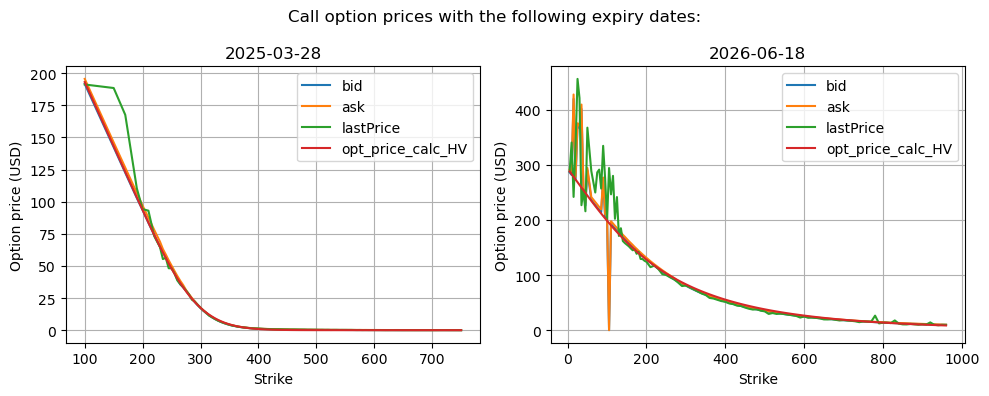

In [60]:
# comparison of the calculated call option prices with data from YF
fig, axes = plt.subplots(1, 2, figsize = (10,4))

calls_opt.plot(x = 'strike', y = ['bid', 'ask', 'lastPrice', 'opt_price_calc_HV'], xlabel = "Strike", ylabel = "Option price (USD)", ax = axes[0])
calls_opt_far.plot(x = 'strike', y = ['bid', 'ask', 'lastPrice', 'opt_price_calc_HV'], xlabel = "Strike", ylabel = "Option price (USD)", ax = axes[1])

fig.suptitle(f"Call option prices with the following expiry dates:")
axes[0].set_title(f"{exp_date}")
axes[1].set_title(f"{exp_date_far}")

fig.tight_layout()

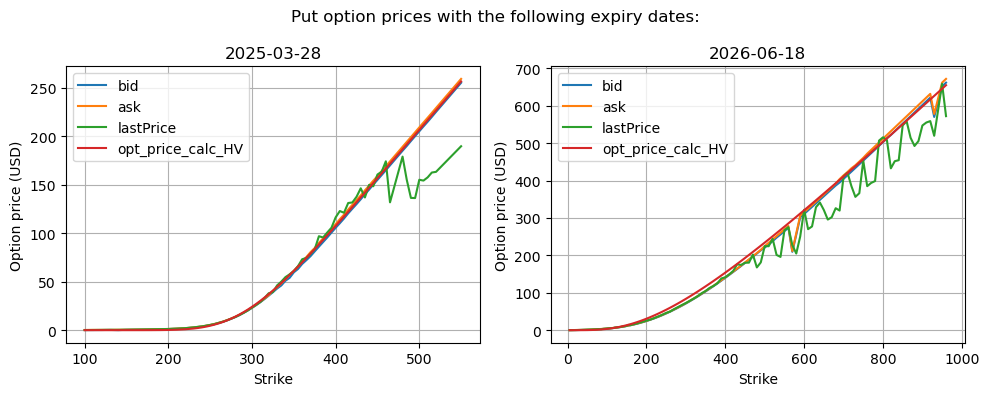

In [61]:
# comparison of the calculated put option prices with data from YF
fig, axes = plt.subplots(1, 2, figsize = (10,4))

puts_opt.plot(x = 'strike', y = ['bid', 'ask', 'lastPrice', 'opt_price_calc_HV'], xlabel = "Strike", ylabel = "Option price (USD)", ax = axes[0])
puts_opt_far.plot(x = 'strike', y = ['bid', 'ask', 'lastPrice', 'opt_price_calc_HV'], xlabel = "Strike", ylabel = "Option price (USD)", ax = axes[1])

fig.suptitle(f"Put option prices with the following expiry dates:")
axes[0].set_title(f"{exp_date}")
axes[1].set_title(f"{exp_date_far}")

fig.tight_layout()

-------

### 5. Implied volatility for the Tesla options using the Brent's method - comparison with the YF data

In [64]:
# calculating implied volatility using the Brent's method
def calc_imp_vol_B(option_type, P0, S0, K, T, r, σ_min, σ_max, prec, max_iter):
    
    def price_diff(iv):
        bsm = BSMmodel(S0, K, T, iv, r)
        
        if option_type == 'call':
            diff = bsm.call_price() - P0
        elif option_type == 'put':
            diff = bsm.put_price() - P0
        
        return diff
    
    return brentq(price_diff, a = σ_min, b = σ_max, xtol = prec, maxiter = max_iter)

In [65]:
# parameters for the iv calculation #####################################
σ_min = 0.0
σ_max = 1000.0
prec = 1.0e-5
max_iter = 10000

In [66]:
# calls and puts dataframes for the iv calculations
iv_calc_calls = pd.DataFrame()
iv_calc_calls[['strike', 'lastPrice', 'ask', 'bid', 'impliedVolatility']] = calls_opt_fil[['strike', 'lastPrice', 'ask', 'bid', 'impliedVolatility']]
iv_calc_calls['P0'] = (iv_calc_calls['bid'] + iv_calc_calls['ask']) / 2
iv_calc_calls['yearsToExpiration'] = calls_opt_fil['daysToExpiration'] / 365
iv_calc_calls['iv_INI'] = σ_hist #iv_calc_calls['P0']/S0 * np.sqrt(2*np.pi / iv_calc_calls['yearsToExpiration'])   # iv ini guess

iv_calc_puts = pd.DataFrame()
iv_calc_puts[['strike', 'lastPrice', 'ask', 'bid', 'impliedVolatility']] = puts_opt_fil[['strike', 'lastPrice', 'ask', 'bid', 'impliedVolatility']]
iv_calc_puts['P0'] = (iv_calc_puts['bid'] + iv_calc_puts['ask']) / 2
iv_calc_puts['yearsToExpiration'] = puts_opt_fil['daysToExpiration'] / 365
iv_calc_puts['iv_INI'] = σ_hist #iv_calc_puts['P0']/S0 * np.sqrt(2*np.pi / iv_calc_puts['yearsToExpiration'])   # iv ini guess

iv_calc_calls_far = pd.DataFrame()
iv_calc_calls_far[['strike', 'lastPrice', 'ask', 'bid', 'impliedVolatility']] = calls_opt_far_fil[['strike', 
                                                                                                   'lastPrice', 'ask', 'bid', 'impliedVolatility']]
iv_calc_calls_far['P0'] = (iv_calc_calls_far['bid'] + iv_calc_calls_far['ask']) / 2
iv_calc_calls_far['yearsToExpiration'] = calls_opt_far_fil['daysToExpiration'] / 365
iv_calc_calls_far['iv_INI'] = σ_hist #iv_calc_calls_far['P0']/S0 * np.sqrt(2*np.pi / iv_calc_calls_far['yearsToExpiration'])   # iv ini guess

iv_calc_puts_far = pd.DataFrame()
iv_calc_puts_far[['strike', 'lastPrice', 'ask', 'bid', 'impliedVolatility']] = puts_opt_far_fil[['strike', 
                                                                                                 'lastPrice', 'ask', 'bid', 'impliedVolatility']]
iv_calc_puts_far['P0'] = (iv_calc_puts_far['bid'] + iv_calc_puts_far['ask']) / 2
iv_calc_puts_far['yearsToExpiration'] = puts_opt_far_fil['daysToExpiration'] / 365
iv_calc_puts_far['iv_INI'] = σ_hist #iv_calc_puts_far['P0']/S0 * np.sqrt(2*np.pi / iv_calc_puts_far['yearsToExpiration'])   # iv ini guess

In [67]:
# calculation of implied volatility for each row in the iv_calc dataframe
iv_calc_calls['IV_calc'] = iv_calc_calls.apply(lambda row: calc_imp_vol_B(
    'call', row['P0'], S0, row['strike'], row['yearsToExpiration'], r, σ_min, σ_max, prec, max_iter), axis = 1)

iv_calc_puts['IV_calc'] = iv_calc_puts.apply(lambda row: calc_imp_vol_B(
    'put', row['P0'], S0, row['strike'], row['yearsToExpiration'], r, σ_min, σ_max, prec, max_iter), axis = 1)

iv_calc_calls_far['IV_calc'] = iv_calc_calls_far.apply(lambda row: calc_imp_vol_B(
    'call', row['P0'], S0, row['strike'], row['yearsToExpiration'], r, σ_min, σ_max, prec, max_iter), axis = 1)

iv_calc_puts_far['IV_calc'] = iv_calc_puts_far.apply(lambda row: calc_imp_vol_B(
    'put', row['P0'], S0, row['strike'], row['yearsToExpiration'], r, σ_min, σ_max, prec, max_iter), axis = 1)

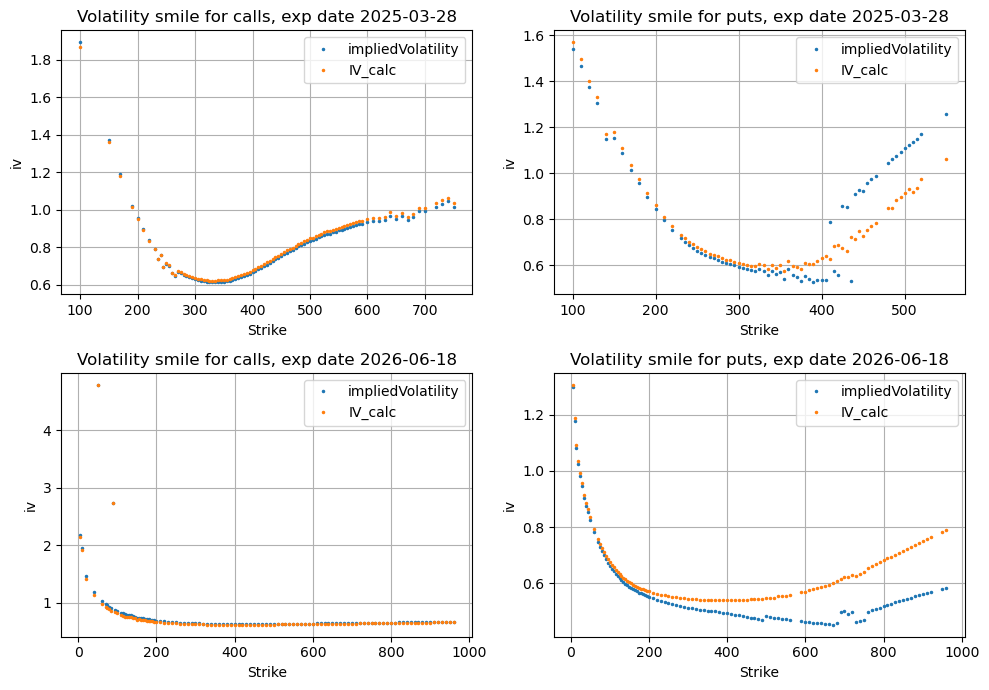

In [68]:
fig, axes = plt.subplots(2, 2, figsize = (10,7))

iv_calc_calls.plot(x = 'strike', y = ['impliedVolatility', 'IV_calc'], 
                   linestyle = '', marker = '.', ms = 3, xlabel = "Strike", ylabel = "iv", ax = axes[0,0])
iv_calc_puts.plot(x = 'strike', y = ['impliedVolatility', 'IV_calc'], 
                  linestyle = '', marker = '.', ms = 3, xlabel = "Strike", ylabel = "iv", ax = axes[0,1])
axes[0,0].set_title(f"Volatility smile for calls, exp date {exp_date}")
axes[0,1].set_title(f"Volatility smile for puts, exp date {exp_date}")

iv_calc_calls_far.plot(x = 'strike', y = ['impliedVolatility', 'IV_calc'], 
                       linestyle = '', marker = '.', ms = 3, xlabel = "Strike", ylabel = "iv", ax = axes[1,0])
iv_calc_puts_far.plot(x = 'strike', y = ['impliedVolatility', 'IV_calc'], 
                      linestyle = '', marker = '.', ms = 3, xlabel = "Strike", ylabel = "iv", ax = axes[1,1])
axes[1,0].set_title(f"Volatility smile for calls, exp date {exp_date_far}")
axes[1,1].set_title(f"Volatility smile for puts, exp date {exp_date_far}")

fig.tight_layout()

-------

### 6. The BSM option prices for the Tesla stocks using calculated implied volatility - comparison with the YF data

In [71]:
# calculating BSM option prices using implied volatility
iv_calc_calls['opt_price_calc_IV'] = iv_calc_calls.apply(lambda row: BSMmodel(
    S0, row['strike'], row['yearsToExpiration'], row['IV_calc'], r).call_price(), axis = 1)

iv_calc_puts['opt_price_calc_IV'] = iv_calc_puts.apply(lambda row: BSMmodel(
    S0, row['strike'], row['yearsToExpiration'], row['IV_calc'], r).put_price(), axis = 1)

iv_calc_calls_far['opt_price_calc_IV'] = iv_calc_calls_far.apply(lambda row: BSMmodel(
    S0, row['strike'], row['yearsToExpiration'], row['IV_calc'], r).call_price(), axis = 1)

iv_calc_puts_far['opt_price_calc_IV'] = iv_calc_puts_far.apply(lambda row: BSMmodel(
    S0, row['strike'], row['yearsToExpiration'], row['IV_calc'], r).put_price(), axis = 1)

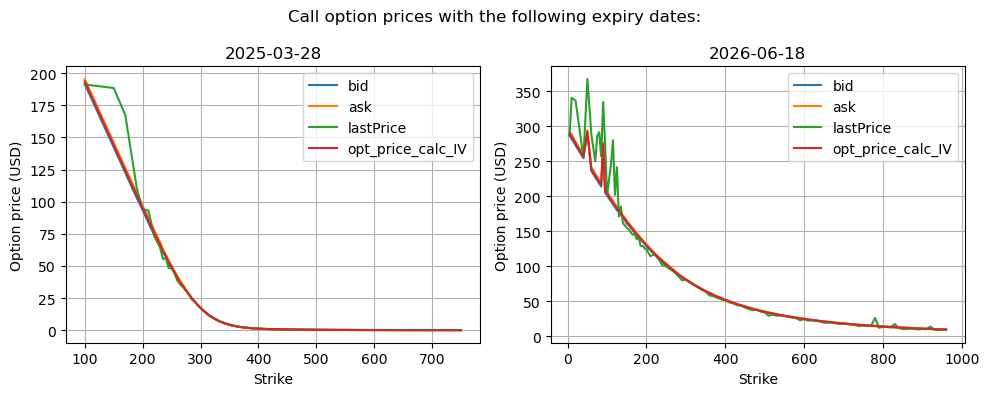

In [72]:
# comparison of the calculated call option prices with data from YF
fig, axes = plt.subplots(1, 2, figsize = (10,4))

iv_calc_calls.plot(x = 'strike', y = ['bid', 'ask', 'lastPrice', 'opt_price_calc_IV'], xlabel = "Strike", ylabel = "Option price (USD)", ax = axes[0])
iv_calc_calls_far.plot(x = 'strike', y = ['bid', 'ask', 'lastPrice', 'opt_price_calc_IV'], xlabel = "Strike", ylabel = "Option price (USD)", ax = axes[1])

fig.suptitle(f"Call option prices with the following expiry dates:")
axes[0].set_title(f"{exp_date}")
axes[1].set_title(f"{exp_date_far}")

fig.tight_layout()

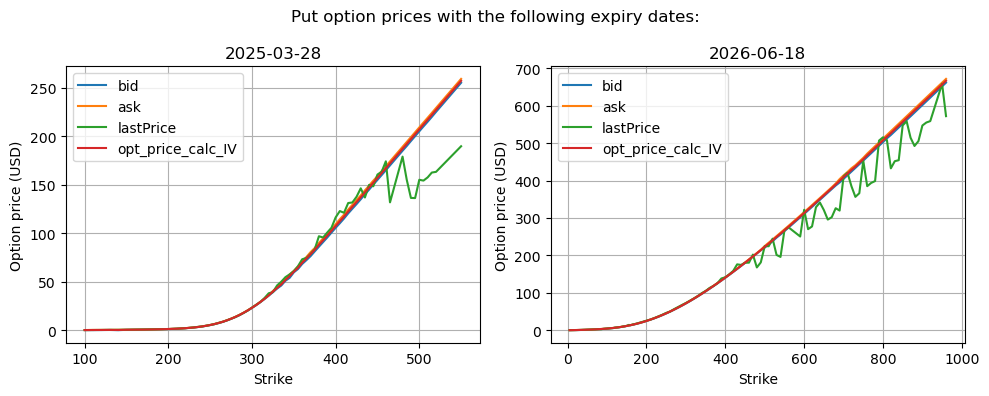

In [73]:
# comparison of the calculated put option prices with data from YF
fig, axes = plt.subplots(1, 2, figsize = (10,4))

iv_calc_puts.plot(x = 'strike', y = ['bid', 'ask', 'lastPrice', 'opt_price_calc_IV'], xlabel = "Strike", ylabel = "Option price (USD)", ax = axes[0])
iv_calc_puts_far.plot(x = 'strike', y = ['bid', 'ask', 'lastPrice', 'opt_price_calc_IV'], xlabel = "Strike", ylabel = "Option price (USD)", ax = axes[1])

fig.suptitle(f"Put option prices with the following expiry dates:")
axes[0].set_title(f"{exp_date}")
axes[1].set_title(f"{exp_date_far}")

fig.tight_layout()

-------

### 7. Principal component analysis (PCA) in volatility modelling \& option pricing for the Tesla stocks

Principal component analysis (PCA) is a statistical method for reducing a cases-by-variables data to its essential features. These principal components are a few linear combinations of the original variables that maximally explain variance of all the variables. PCA results in a low-dimensional representation of original data using only these few major components. The intuition behind PCA is that the most important information is drawn from the features by eliminating redundancy and noise.

First, the implied and PCA-reconstructed volatility surfaces along with the BSM option prices calculated using the implied and PCA-adjusted volatilities for two selected maturities, will be compared.

In [77]:
# converting the IV surfaces to numpy arrays
iv_surface_calls_arr = iv_surface_calls.values
iv_surface_puts_arr = iv_surface_puts.values

# performing PCA on the volatility surfaces
pca_calls = PCA(n_components = 3)   # number of top principal components #####################################
pca_calls.fit(iv_surface_calls_arr)
#
pca_puts = PCA(n_components = 3)   # number of top principal components #####################################
pca_puts.fit(iv_surface_puts_arr)

# reconstructing the volatility surface using PCA
approx_iv_surface_calls = pca_calls.inverse_transform(pca_calls.transform(iv_surface_calls_arr))
approx_iv_surface_puts = pca_puts.inverse_transform(pca_puts.transform(iv_surface_puts_arr))

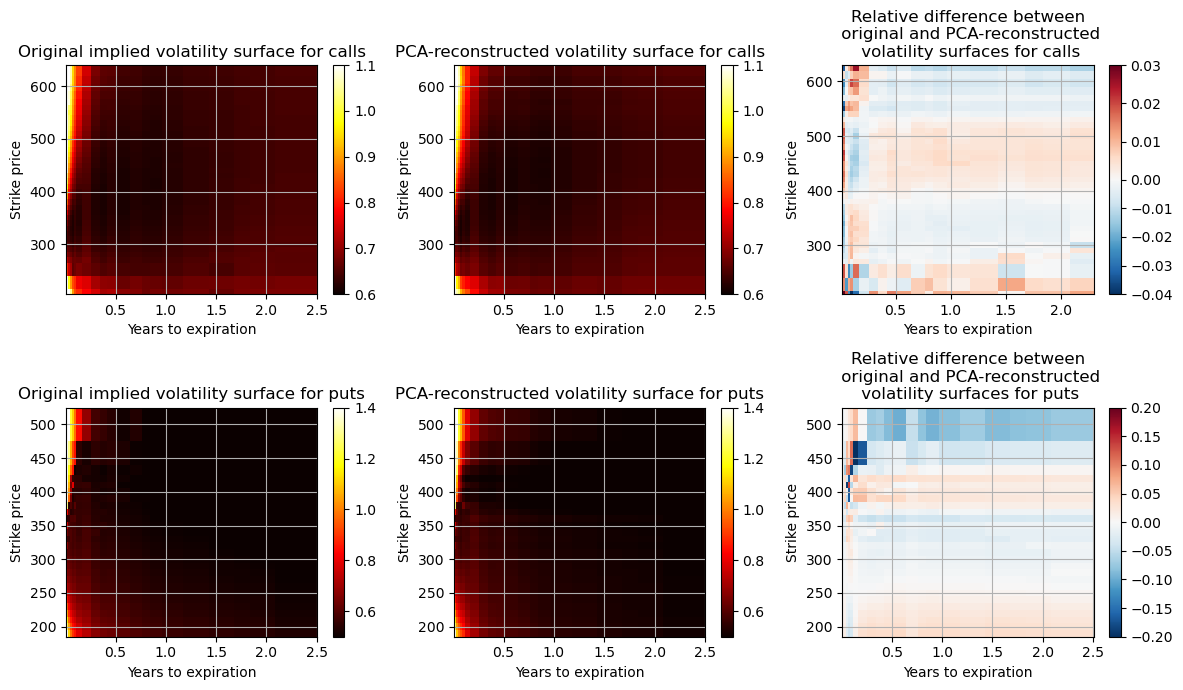

In [78]:
# plotting original vs. PCA-reconstructed volatility surfaces with relative differences
calls_strikes = iv_surface_calls.index.values
calls_maturities = iv_surface_calls.columns.values
#
puts_strikes = iv_surface_puts.index.values
puts_maturities = iv_surface_puts.columns.values

calls_diff = (iv_surface_calls_arr - approx_iv_surface_calls) / iv_surface_calls_arr
puts_diff = (iv_surface_puts_arr - approx_iv_surface_puts) / iv_surface_puts_arr

fig, ax = plt.subplots(2, 3, figsize = (12,7))

xc, yc = np.meshgrid(calls_maturities, calls_strikes)
xp, yp = np.meshgrid(puts_maturities, puts_strikes)

ax[0,0].set_title("Original implied volatility surface for calls")
ax[0,0].set_xlabel("Years to expiration")
ax[0,0].set_ylabel("Strike price")
#c = ax[0,0].pcolormesh(xc, yc, iv_surface_calls_arr, cmap = 'hot', vmin = iv_surface_calls_arr.min(), vmax = iv_surface_calls_arr.max())
c = ax[0,0].pcolormesh(xc, yc, iv_surface_calls_arr, cmap = 'hot', vmin = 0.6, vmax = 1.1)
fig.colorbar(c, ax = ax[0,0])

ax[0,1].set_title("PCA-reconstructed volatility surface for calls")
ax[0,1].set_xlabel("Years to expiration")
ax[0,1].set_ylabel("Strike price")
#c = ax[0,1].pcolormesh(xc, yc, approx_iv_surface_calls, cmap = 'hot', vmin = approx_iv_surface_calls.min(), vmax = approx_iv_surface_calls.max())
c = ax[0,1].pcolormesh(xc, yc, approx_iv_surface_calls, cmap = 'hot', vmin = 0.6, vmax = 1.1)
fig.colorbar(c, ax = ax[0,1])

ax[0,2].set_title("Relative difference between\n original and PCA-reconstructed\n volatility surfaces for calls")
ax[0,2].set_xlabel("Years to expiration")
ax[0,2].set_ylabel("Strike price")
ax[0,2].axis([xc.min(), xc.max(), yc.min(), yc.max()])
#tsn = TwoSlopeNorm(vmin = calls_diff.min(), vcenter = 0.0, vmax = calls_diff.max())
tsn = TwoSlopeNorm(vmin = -0.04, vcenter = 0.0, vmax = 0.03001)
c = ax[0,2].pcolormesh(xc, yc, calls_diff, norm = tsn, cmap = 'RdBu_r')
fig.colorbar(c, ax = ax[0,2])

ax[1,0].set_title("Original implied volatility surface for puts")
ax[1,0].set_xlabel("Years to expiration")
ax[1,0].set_ylabel("Strike price")
#c = ax[1,0].pcolormesh(xp, yp, iv_surface_puts_arr, cmap = 'hot', vmin = iv_surface_puts_arr.min(), vmax = iv_surface_puts_arr.max())
c = ax[1,0].pcolormesh(xp, yp, iv_surface_puts_arr, cmap = 'hot', vmin = 0.5, vmax = 1.4)
fig.colorbar(c, ax = ax[1,0])

ax[1,1].set_title("PCA-reconstructed volatility surface for puts")
ax[1,1].set_xlabel("Years to expiration")
ax[1,1].set_ylabel("Strike price")
#c = ax[1,1].pcolormesh(xp, yp, approx_iv_surface_puts, cmap = 'hot', vmin = approx_iv_surface_puts.min(), vmax = approx_iv_surface_puts.max())
c = ax[1,1].pcolormesh(xp, yp, approx_iv_surface_puts, cmap = 'hot', vmin = 0.5, vmax = 1.4)
fig.colorbar(c, ax = ax[1,1])

ax[1,2].set_title("Relative difference between\n original and PCA-reconstructed\n volatility surfaces for puts")
ax[1,2].set_xlabel("Years to expiration")
ax[1,2].set_ylabel("Strike price")
#tsn = TwoSlopeNorm(vmin = puts_diff.min(), vcenter = 0.0, vmax = puts_diff.max())
tsn = TwoSlopeNorm(vmin = -0.2, vcenter = 0.0, vmax = 0.2)
c = ax[1,2].pcolormesh(xp, yp, puts_diff, norm = tsn, cmap = 'RdBu_r')
fig.colorbar(c, ax = ax[1,2])

fig.tight_layout()

In [79]:
# computing option prices using PCA-adjusted volatilities
calls_PCA = np.zeros(iv_surface_calls_arr.shape)
puts_PCA = np.zeros(iv_surface_puts_arr.shape)

for i, K in enumerate(calls_strikes):
    for j, T in enumerate(calls_maturities):
        σ = approx_iv_surface_calls[i,j]   # PCA-reconstructed volatility
        calls_PCA[i,j] = BSMmodel(S0, K, T, σ, r).call_price()
#
for i, K in enumerate(puts_strikes):
    for j, T in enumerate(puts_maturities):
        σ = approx_iv_surface_puts[i,j]
        puts_PCA[i,j] = BSMmodel(S0, K, T, σ, r).put_price()

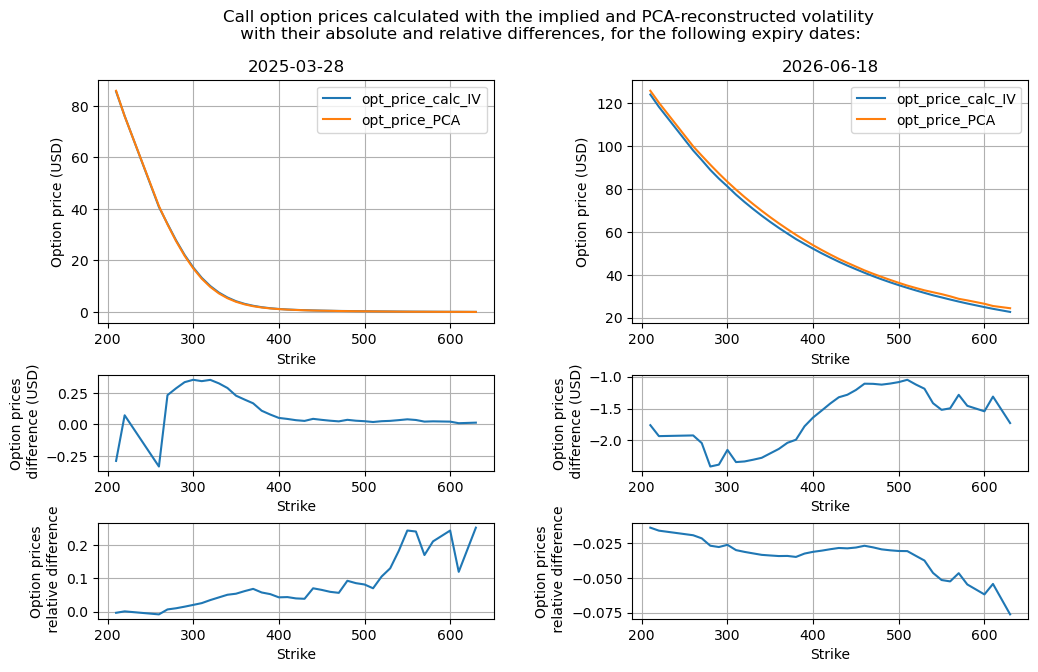

In [80]:
# plotting calculated with the implied vs. PCA-reconstructed volatility BSM call option prices with absolute and relative differences
aux_df = pd.DataFrame(calls_PCA)
#
calls_PCA_df_i_exp = pd.DataFrame()
calls_PCA_df_i_exp['strike'] = calls_strikes
calls_PCA_df_i_exp['opt_price_PCA'] = aux_df.loc[:,i_exp]

calls_PCA_df_i_exp = pd.merge(calls_PCA_df_i_exp, iv_calc_calls[['strike', 'opt_price_calc_IV']], on = 'strike', how = 'inner')
#
calls_PCA_df_i_exp['diff'] = calls_PCA_df_i_exp['opt_price_calc_IV'] - calls_PCA_df_i_exp['opt_price_PCA']
calls_PCA_df_i_exp['rel_diff'] = (calls_PCA_df_i_exp['opt_price_calc_IV'] - calls_PCA_df_i_exp['opt_price_PCA']) / calls_PCA_df_i_exp['opt_price_calc_IV']

calls_PCA_df_i_exp_far = pd.DataFrame()
calls_PCA_df_i_exp_far['strike'] = calls_strikes
calls_PCA_df_i_exp_far['opt_price_PCA'] = aux_df.loc[:,len(aux_df.columns) + i_exp_far]

calls_PCA_df_i_exp_far = pd.merge(calls_PCA_df_i_exp_far, iv_calc_calls_far[['strike', 'opt_price_calc_IV']], on = 'strike', how = 'inner')
#
calls_PCA_df_i_exp_far['diff'] = calls_PCA_df_i_exp_far['opt_price_calc_IV'] - calls_PCA_df_i_exp_far['opt_price_PCA']
calls_PCA_df_i_exp_far['rel_diff'] = (calls_PCA_df_i_exp_far['opt_price_calc_IV'] 
                                      - calls_PCA_df_i_exp_far['opt_price_PCA']) / calls_PCA_df_i_exp_far['opt_price_calc_IV']


fig = figure(figsize = (12,7))

plot1 = plt.subplot2grid((4,2),(0,0), rowspan = 2)
plot2 = plt.subplot2grid((4,2),(0,1), rowspan = 2)
plot3 = plt.subplot2grid((4,2),(2,0))
plot4 = plt.subplot2grid((4,2),(3,0))
plot5 = plt.subplot2grid((4,2),(2,1))
plot6 = plt.subplot2grid((4,2),(3,1))

plot1.plot(calls_PCA_df_i_exp['strike'], calls_PCA_df_i_exp[['opt_price_calc_IV', 'opt_price_PCA']], label = ['opt_price_calc_IV', 'opt_price_PCA'])
plot1.set_xlabel("Strike")
plot1.set_ylabel("Option price (USD)")
plot1.legend()

plot3.plot(calls_PCA_df_i_exp['strike'], calls_PCA_df_i_exp['diff'])
plot3.set_xlabel("Strike")
plot3.set_ylabel("Option prices\n difference (USD)")

plot4.plot(calls_PCA_df_i_exp['strike'], calls_PCA_df_i_exp['rel_diff'])
plot4.set_xlabel("Strike")
plot4.set_ylabel("Option prices\n relative difference")

plot2.plot(calls_PCA_df_i_exp_far['strike'], calls_PCA_df_i_exp_far[['opt_price_calc_IV', 'opt_price_PCA']], 
           label = ['opt_price_calc_IV', 'opt_price_PCA'])
plot2.set_xlabel("Strike")
plot2.set_ylabel("Option price (USD)")
plot2.legend()

plot5.plot(calls_PCA_df_i_exp_far['strike'], calls_PCA_df_i_exp_far['diff'])
plot5.set_xlabel("Strike")
plot5.set_ylabel("Option prices\n difference (USD)")

plot6.plot(calls_PCA_df_i_exp_far['strike'], calls_PCA_df_i_exp_far['rel_diff'])
plot6.set_xlabel("Strike")
plot6.set_ylabel("Option prices\n relative difference")

plt.suptitle(f"Call option prices calculated with the implied and PCA-reconstructed volatility\n with their absolute and relative differences, "
             f"for the following expiry dates:")
plot1.set_title(f"{exp_date}")
plot2.set_title(f"{exp_date_far}")

plt.subplots_adjust(wspace = 0.35, hspace = 0.55)
plt.show()

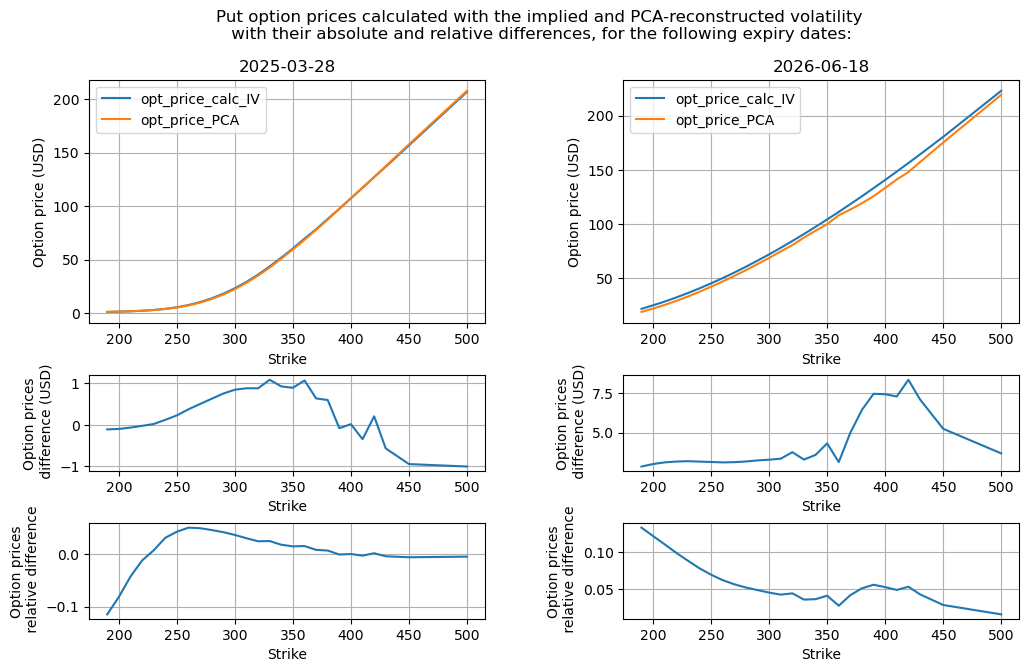

In [81]:
# plotting calculated with the implied vs. PCA-reconstructed volatility BSM put option prices with absolute and relative differences
aux_df = pd.DataFrame(puts_PCA)
#
puts_PCA_df_i_exp = pd.DataFrame()
puts_PCA_df_i_exp['strike'] = puts_strikes
puts_PCA_df_i_exp['opt_price_PCA'] = aux_df.loc[:,i_exp]

puts_PCA_df_i_exp = pd.merge(puts_PCA_df_i_exp, iv_calc_puts[['strike', 'opt_price_calc_IV']], on = 'strike', how = 'inner')
#
puts_PCA_df_i_exp['diff'] = puts_PCA_df_i_exp['opt_price_calc_IV'] - puts_PCA_df_i_exp['opt_price_PCA']
puts_PCA_df_i_exp['rel_diff'] = (puts_PCA_df_i_exp['opt_price_calc_IV'] - puts_PCA_df_i_exp['opt_price_PCA']) / puts_PCA_df_i_exp['opt_price_calc_IV']

puts_PCA_df_i_exp_far = pd.DataFrame()
puts_PCA_df_i_exp_far['strike'] = puts_strikes
puts_PCA_df_i_exp_far['opt_price_PCA'] = aux_df.loc[:,len(aux_df.columns) + i_exp_far]

puts_PCA_df_i_exp_far = pd.merge(puts_PCA_df_i_exp_far, iv_calc_puts_far[['strike', 'opt_price_calc_IV']], on = 'strike', how = 'inner')
#
puts_PCA_df_i_exp_far['diff'] = puts_PCA_df_i_exp_far['opt_price_calc_IV'] - puts_PCA_df_i_exp_far['opt_price_PCA']
puts_PCA_df_i_exp_far['rel_diff'] = (puts_PCA_df_i_exp_far['opt_price_calc_IV'] 
                                     - puts_PCA_df_i_exp_far['opt_price_PCA']) / puts_PCA_df_i_exp_far['opt_price_calc_IV']


fig = figure(figsize = (12,7))

plot1 = plt.subplot2grid((4,2),(0,0), rowspan = 2)
plot2 = plt.subplot2grid((4,2),(0,1), rowspan = 2)
plot3 = plt.subplot2grid((4,2),(2,0))
plot4 = plt.subplot2grid((4,2),(3,0))
plot5 = plt.subplot2grid((4,2),(2,1))
plot6 = plt.subplot2grid((4,2),(3,1))

plot1.plot(puts_PCA_df_i_exp['strike'], puts_PCA_df_i_exp[['opt_price_calc_IV', 'opt_price_PCA']], label = ['opt_price_calc_IV', 'opt_price_PCA'])
plot1.set_xlabel("Strike")
plot1.set_ylabel("Option price (USD)")
plot1.legend()

plot3.plot(puts_PCA_df_i_exp['strike'], puts_PCA_df_i_exp['diff'])
plot3.set_xlabel("Strike")
plot3.set_ylabel("Option prices\n difference (USD)")

plot4.plot(puts_PCA_df_i_exp['strike'], puts_PCA_df_i_exp['rel_diff'])
plot4.set_xlabel("Strike")
plot4.set_ylabel("Option prices\n relative difference")

plot2.plot(puts_PCA_df_i_exp_far['strike'], puts_PCA_df_i_exp_far[['opt_price_calc_IV', 'opt_price_PCA']], label = ['opt_price_calc_IV', 'opt_price_PCA'])
plot2.set_xlabel("Strike")
plot2.set_ylabel("Option price (USD)")
plot2.legend()

plot5.plot(puts_PCA_df_i_exp_far['strike'], puts_PCA_df_i_exp_far['diff'])
plot5.set_xlabel("Strike")
plot5.set_ylabel("Option prices\n difference (USD)")

plot6.plot(puts_PCA_df_i_exp_far['strike'], puts_PCA_df_i_exp_far['rel_diff'])
plot6.set_xlabel("Strike")
plot6.set_ylabel("Option prices\n relative difference")

plt.suptitle(f"Put option prices calculated with the implied and PCA-reconstructed volatility\n with their absolute and relative differences, "
             f"for the following expiry dates:")
plot1.set_title(f"{exp_date}")
plot2.set_title(f"{exp_date_far}")

plt.subplots_adjust(wspace = 0.35, hspace = 0.55)
plt.show()

##### ********************************************************************************************************************************************************************************************

In [83]:
# parameters for Monte-Carlo option pricing with Heston + PCA and martingales techniques, for final comparison #####################################
M = 10000   # number of simulations

T_i_exp = calls_opt.loc[1,'daysToExpiration'] / 365   # time horizon [years]
T_i_exp_far = calls_opt_far.loc[1,'daysToExpiration'] / 365

K1 = 300   # strike prices
K2 = 500

##### ********************************************************************************************************************************************************************************************

Secondly, option prices will be calculated according to the stochastic volatility Heston model with the PCA-forecasted volatility.

In [86]:
# computing 30-day rolling volatility (annualized)
volatility = log_returns.rolling(window = 30).std() * np.sqrt(252)

# preparing volatility data for PCA
lags = 10   # number of lagged volatility features #####################################
vol_matrix = np.column_stack([volatility.shift(i) for i in range(lags)])
vol_matrix = vol_matrix[lags-1:]   # starting from the first row without NaNs
vol_matrix = vol_matrix[~np.isnan(vol_matrix).any(axis = 1)]   # dropping NaN rows

# performing PCA
pca = PCA(n_components = 3)   # number of top principal components #####################################
pca.fit(vol_matrix)

# forecasting future volatility using PCA, filtering out noise in volatility
vol_pca = pca.transform(vol_matrix)   # projecting data onto principal components
forecasted_vol = pca.inverse_transform(vol_pca)[:,0]   # reconstructing first volatility series

In [87]:
# estimating the Heston model parameters
def heston_calibration(params, returns, dt):
    κ, θ, σ, v0, ρ = params
    
    v_t = np.zeros_like(returns)
    v_t[0] = v0
    
    for t in range(1, len(returns)):
        v_t[t] = v_t[t-1] + κ * (θ - v_t[t-1]) * dt + σ * np.sqrt(v_t[t-1] * dt) * np.random.randn()
        
    return np.sum((returns ** 2 - v_t) ** 2)   # minimizing squared errors

def estimate_heston_parameters(returns, ini_variance, dt = 1 / trading_days):
    initial_guess = [2.0, 0.02, 0.1, ini_variance, -0.5]
    
    result = minimize(heston_calibration, initial_guess, args = (returns, dt), method = 'Nelder-Mead')
    
    return result.x

params = estimate_heston_parameters(log_returns.values, forecasted_vol[-1] ** 2)
print(f"The Heston model parameters: [κ, θ, σ, v0, ρ] = {params}.")

The Heston model parameters: [κ, θ, σ, v0, ρ] = [ 2.01346851  0.02017016  0.10456932  0.30392955 -0.50309073].


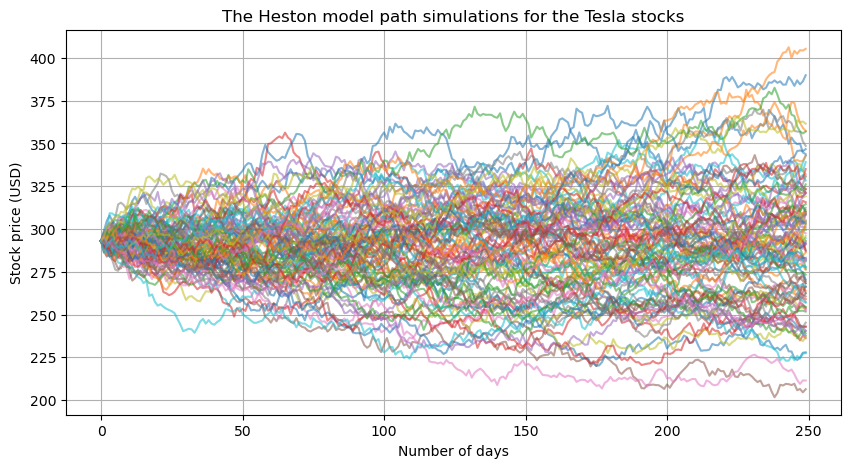

In [88]:
# simulating stock price paths using the Heston model
def heston_simulation(S0, T, N, M, params):
    dt = T / N
    κ, θ, σ, v0, ρ = params
    
    S = np.zeros((N,M))
    v = np.zeros((N,M))
    S[0,:] = S0
    v[0,:] = v0
    
    for t in range(1,N):
        W1 = np.random.randn(M)
        W2 = ρ * W1 + np.sqrt(1 - ρ**2) * np.random.randn(M)
        v[t] = np.maximum(v[t-1] + κ * (θ - v[t-1]) * dt + σ * np.sqrt(np.maximum(v[t-1], 0) * dt) * W1, 0)
        S[t] = S[t-1] * np.exp(-v[t-1] * dt/2 + np.sqrt(v[t-1] * dt) * W2)
    
    return S

S_simulated_i_exp = heston_simulation(S0, T_i_exp, trading_days, M, params)
S_simulated_i_exp_far = heston_simulation(S0, T_i_exp_far, trading_days, M, params)

# plotting results - 100 simulated paths
plt.figure(figsize = (10,5))
plt.plot(S_simulated_i_exp[:,:100], alpha = 0.55)
plt.xlabel("Number of days")
plt.ylabel("Stock price (USD)")
plt.title("The Heston model path simulations for the Tesla stocks")
plt.show()

In [89]:
# Monte-Carlo option pricing
def monte_carlo_option_price(S, K, r, T, option_type):
    S = np.array(S)
    
    # accessing final stock prices for all simulated paths at time T (last row)
    final_prices = S[-1,:]
    
    # calculating payoffs for all paths at the final time step
    if option_type == 'call':
        payoffs = np.maximum(final_prices - K, 0)
    else:
        payoffs = np.maximum(K - final_prices, 0)
    
    # discounting the payoffs back to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)
    
    return option_price

call_price_HPCA_i_exp_K1 = monte_carlo_option_price(S_simulated_i_exp, K1, r, T_i_exp, 'call')
put_price_HPCA_i_exp_K1 = monte_carlo_option_price(S_simulated_i_exp, K1, r, T_i_exp, 'put')
call_price_HPCA_i_exp_far_K1 = monte_carlo_option_price(S_simulated_i_exp_far, K1, r, T_i_exp_far, 'call')
put_price_HPCA_i_exp_far_K1 = monte_carlo_option_price(S_simulated_i_exp_far, K1, r, T_i_exp_far, 'put')
#
call_price_HPCA_i_exp_K2 = monte_carlo_option_price(S_simulated_i_exp, K2, r, T_i_exp, 'call')
put_price_HPCA_i_exp_K2 = monte_carlo_option_price(S_simulated_i_exp, K2, r, T_i_exp, 'put')
call_price_HPCA_i_exp_far_K2 = monte_carlo_option_price(S_simulated_i_exp_far, K2, r, T_i_exp_far, 'call')
put_price_HPCA_i_exp_far_K2 = monte_carlo_option_price(S_simulated_i_exp_far, K2, r, T_i_exp_far, 'put')

-------

### 8. Martingales in the Monte-Carlo option pricing for the Tesla stocks

A martingale is a mathematical concept from the probability theory, which describes a stochastic process where the expected value of the next observation is equal to the present value. A process $X_t$ is a martingale with respect to filtration $F_t$ when $\mathbb{E}[X_{t+1}∣F_t] = X_t$. This means that, on average, future values of the process do not provide an opportunity for a systematic gain or loss.

The martingale approach in the Monte-Carlo option pricing is crucial for making simulations efficient and arbitrage-free. The key idea is that in a risk-neutral world the discounted price of an asset should follow a martingale. This ensures that the expected future prices are equal to the current price, preventing arbitrage opportunities. The discounted asset price process $\tilde{S}_t = e^{−rt}S_t$ is a martingale under the risk-neutral measure $\mathbb{Q}$, i.e., $\mathbb{E}^\mathbb{Q}[\tilde{S}_{t+1}∣F_t]=\tilde{S}_t$, where $S_t$ is the asset price at time $t$, $r$ is the risk-free rate, and $F_t$ represents the filtration (history of price movements).

Variance reduction techniques can improve the efficiency of Monte-Carlo simulations, leading to faster convergence and more accurate option pricing. Antithetic variates is a method in which instead of one random path per simulation, two paths are generated - one using $Z \sim N(0,1)$ and another using $−Z$ (negated random variable). This helps to reduce variance since both paths compensate for randomness. Another method of variance reduction is control variates (in finance using stock price as a martingale). The expected value of the discounted stock price should equal the initial price $S_0$ in a risk-neutral world, that is $\mathbb{E}[e^{−rT} S_T] = S_0$. The option payoff is adjusted using this control variate.

In [93]:
# generating standard normal random numbers
np.random.seed(42)
Z = np.random.standard_normal((trading_days,M))   # random variables for the Monte-Carlo procedure
Z_antithetic = -Z   # antithetic variates

# simulating stock price paths using the geometric brownian motion
def simulate_stock_paths(r, Z, N):
    dt = T / N
    
    S = np.zeros((N+1,M))
    S[0] = S0
    
    for t in range(1,N+1):
        S[t] = S[t-1] * np.exp((r - σ_hist**2 / 2) * dt + σ_hist * np.sqrt(dt) * Z[t-1])
        
    return S

# antithetic variates technique: generating paths for both channels
paths1 = simulate_stock_paths(r, Z, trading_days)
paths2 = simulate_stock_paths(r, Z_antithetic, trading_days)

# computing option payoffs for the above sets
call_payoffs_K1_1 = np.maximum(paths1[-1] - K1, 0)
call_payoffs_K1_2 = np.maximum(paths2[-1] - K1, 0)
call_payoffs_K2_1 = np.maximum(paths1[-1] - K2, 0)
call_payoffs_K2_2 = np.maximum(paths2[-1] - K2, 0)
#
put_payoffs_K1_1 = np.maximum(K1 - paths1[-1], 0)
put_payoffs_K1_2 = np.maximum(K1 - paths2[-1], 0)
put_payoffs_K2_1 = np.maximum(K2 - paths1[-1], 0)
put_payoffs_K2_2 = np.maximum(K2 - paths2[-1], 0)

# computing discounted payoff averages (antithetic variates)
call_payoffs_K1_avg = (call_payoffs_K1_1 + call_payoffs_K1_2) / 2
call_payoffs_K2_avg = (call_payoffs_K2_1 + call_payoffs_K2_2) / 2
put_payoffs_K1_avg = (put_payoffs_K1_1 + put_payoffs_K1_2) / 2
put_payoffs_K2_avg = (put_payoffs_K2_1 + put_payoffs_K2_2) / 2
#
call_option_price_antithetic_K1_i_exp = np.exp(-r * T_i_exp) * np.mean(call_payoffs_K1_avg)
call_option_price_antithetic_K2_i_exp = np.exp(-r * T_i_exp) * np.mean(call_payoffs_K2_avg)
call_option_price_antithetic_K1_i_exp_far = np.exp(-r * T_i_exp_far) * np.mean(call_payoffs_K1_avg)
call_option_price_antithetic_K2_i_exp_far = np.exp(-r * T_i_exp_far) * np.mean(call_payoffs_K2_avg)
#
put_option_price_antithetic_K1_i_exp = np.exp(-r * T_i_exp) * np.mean(put_payoffs_K1_avg)
put_option_price_antithetic_K2_i_exp = np.exp(-r * T_i_exp) * np.mean(put_payoffs_K2_avg)
put_option_price_antithetic_K1_i_exp_far = np.exp(-r * T_i_exp_far) * np.mean(put_payoffs_K1_avg)
put_option_price_antithetic_K2_i_exp_far = np.exp(-r * T_i_exp_far) * np.mean(put_payoffs_K2_avg)

# control variate technique: using stock price as a martingale
control_variate_i_exp = np.exp(-r * T_i_exp) * (paths1[-1] + paths2[-1]) / 2   # expected stock value
control_variate_i_exp_far = np.exp(-r * T_i_exp_far) * (paths1[-1] + paths2[-1]) / 2
#
call_cov_matrix_K1_i_exp = np.cov(call_payoffs_K1_avg, control_variate_i_exp)
call_cov_matrix_K2_i_exp = np.cov(call_payoffs_K2_avg, control_variate_i_exp)
call_cov_matrix_K1_i_exp_far = np.cov(call_payoffs_K1_avg, control_variate_i_exp_far)
call_cov_matrix_K2_i_exp_far = np.cov(call_payoffs_K2_avg, control_variate_i_exp_far)
#
put_cov_matrix_K1_i_exp = np.cov(put_payoffs_K1_avg, control_variate_i_exp)
put_cov_matrix_K2_i_exp = np.cov(put_payoffs_K2_avg, control_variate_i_exp)
put_cov_matrix_K1_i_exp_far = np.cov(put_payoffs_K1_avg, control_variate_i_exp_far)
put_cov_matrix_K2_i_exp_far = np.cov(put_payoffs_K2_avg, control_variate_i_exp_far)
#
call_λ_K1_i_exp = call_cov_matrix_K1_i_exp[0,1] / call_cov_matrix_K1_i_exp[1,1]   # regression coefficient
call_λ_K2_i_exp = call_cov_matrix_K2_i_exp[0,1] / call_cov_matrix_K2_i_exp[1,1]
call_λ_K1_i_exp_far = call_cov_matrix_K1_i_exp_far[0,1] / call_cov_matrix_K1_i_exp_far[1,1]
call_λ_K2_i_exp_far = call_cov_matrix_K2_i_exp_far[0,1] / call_cov_matrix_K2_i_exp_far[1,1]
#
put_λ_K1_i_exp = put_cov_matrix_K1_i_exp[0,1] / put_cov_matrix_K1_i_exp[1,1]
put_λ_K2_i_exp = put_cov_matrix_K2_i_exp[0,1] / put_cov_matrix_K2_i_exp[1,1]
put_λ_K1_i_exp_far = put_cov_matrix_K1_i_exp_far[0,1] / put_cov_matrix_K1_i_exp_far[1,1]
put_λ_K2_i_exp_far = put_cov_matrix_K2_i_exp_far[0,1] / put_cov_matrix_K2_i_exp_far[1,1]

# adjusted payoff with control variate
call_adjusted_payoffs_K1_i_exp = call_payoffs_K1_avg - call_λ_K1_i_exp * (control_variate_i_exp - S0)
call_adjusted_payoffs_K2_i_exp = call_payoffs_K2_avg - call_λ_K2_i_exp * (control_variate_i_exp - S0)
call_adjusted_payoffs_K1_i_exp_far = call_payoffs_K1_avg - call_λ_K1_i_exp_far * (control_variate_i_exp_far - S0)
call_adjusted_payoffs_K2_i_exp_far = call_payoffs_K2_avg - call_λ_K2_i_exp_far * (control_variate_i_exp_far - S0)
#
put_adjusted_payoffs_K1_i_exp = put_payoffs_K1_avg - put_λ_K1_i_exp * (control_variate_i_exp - S0)
put_adjusted_payoffs_K2_i_exp = put_payoffs_K2_avg - put_λ_K2_i_exp * (control_variate_i_exp - S0)
put_adjusted_payoffs_K1_i_exp_far = put_payoffs_K1_avg - put_λ_K1_i_exp_far * (control_variate_i_exp_far - S0)
put_adjusted_payoffs_K2_i_exp_far = put_payoffs_K2_avg - put_λ_K2_i_exp_far * (control_variate_i_exp_far - S0)
#
call_option_price_control_variate_K1_i_exp = np.exp(-r * T_i_exp) * np.mean(call_adjusted_payoffs_K1_i_exp)
call_option_price_control_variate_K2_i_exp = np.exp(-r * T_i_exp) * np.mean(call_adjusted_payoffs_K2_i_exp)
call_option_price_control_variate_K1_i_exp_far = np.exp(-r * T_i_exp_far) * np.mean(call_adjusted_payoffs_K1_i_exp_far)
call_option_price_control_variate_K2_i_exp_far = np.exp(-r * T_i_exp_far) * np.mean(call_adjusted_payoffs_K2_i_exp_far)
#
put_option_price_control_variate_K1_i_exp = np.exp(-r * T_i_exp) * np.mean(put_adjusted_payoffs_K1_i_exp)
put_option_price_control_variate_K2_i_exp = np.exp(-r * T_i_exp) * np.mean(put_adjusted_payoffs_K2_i_exp)
put_option_price_control_variate_K1_i_exp_far = np.exp(-r * T_i_exp_far) * np.mean(put_adjusted_payoffs_K1_i_exp_far)
put_option_price_control_variate_K2_i_exp_far = np.exp(-r * T_i_exp_far) * np.mean(put_adjusted_payoffs_K2_i_exp_far)

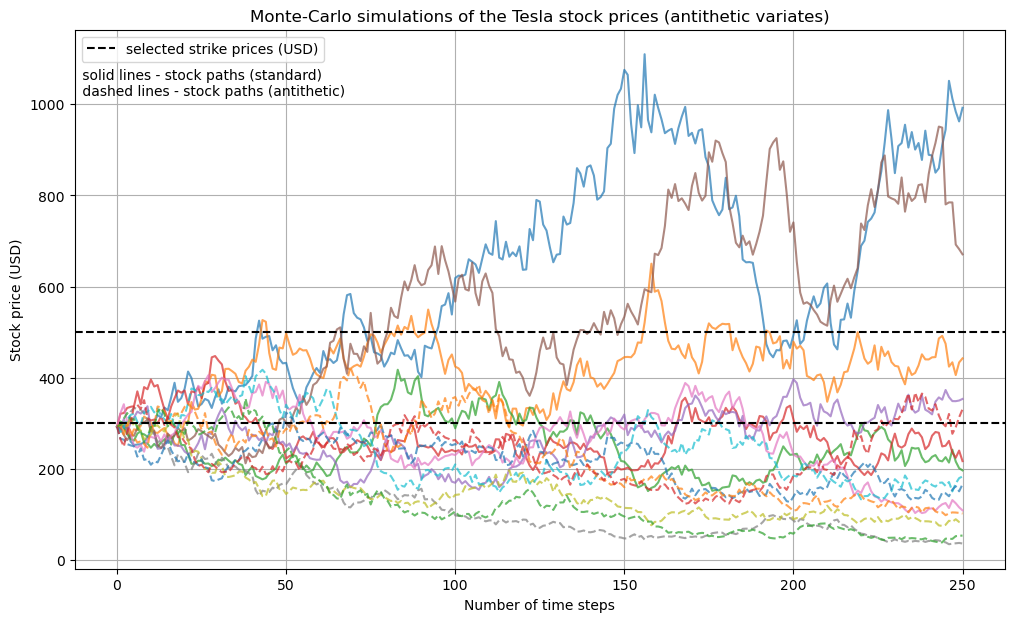

In [94]:
# plotting a few simulated stock price paths
plt.figure(figsize = (12,7))
plt.text(-11.5, 1020, " solid lines - stock paths (standard)\n dashed lines - stock paths (antithetic)", fontsize = 10)
plt.plot(paths1[:, :7], alpha=0.7)
plt.plot(paths2[:, :7], linestyle = '--', alpha=0.7)
plt.axhline(K1, color = 'black', linestyle = '--', label = "selected strike prices (USD)")
plt.axhline(K2, color = 'black', linestyle = '--')
plt.title("Monte-Carlo simulations of the Tesla stock prices (antithetic variates)")
plt.xlabel("Number of time steps")
plt.ylabel("Stock price (USD)")
plt.legend(loc = 'upper left')
plt.show()

-------

In [96]:
cols = pd.MultiIndex.from_tuples([('call', K1), ('call', K2), ('put', K1), ('put', K2)], names = ['option type', 'strike (USD)'])

idx = pd.MultiIndex.from_tuples([(exp_date, 'Yahoo Finance'), (exp_date, 'BSM + historical volatility'), (exp_date, 'BSM + implied volatility'), 
                                 (exp_date, 'BSM + PCA volatility'), (exp_date, 'Heston + PCA volatility'), 
                                 (exp_date, 'martingales - antithetic variates'), (exp_date, 'martingales - control variate'), 
                                 (exp_date_far, 'Yahoo Finance'), (exp_date_far, 'BSM + historical volatility'), 
                                 (exp_date_far, 'BSM + implied volatility'), (exp_date_far, 'BSM + PCA volatility'), 
                                 (exp_date_far, 'Heston + PCA volatility'), (exp_date_far, 'martingales - antithetic variates'), 
                                 (exp_date_far, 'martingales - control variate')], names = ['maturity date', 'source/method'])

opt_prices = np.zeros((14, 4))
#
opt_prices[0,0] = round(iv_calc_calls[(iv_calc_calls['strike'] == K1)]['P0'], 2)
opt_prices[0,1] = round(iv_calc_calls[(iv_calc_calls['strike'] == K2)]['P0'], 2)
opt_prices[0,2] = round(iv_calc_puts[(iv_calc_puts['strike'] == K1)]['P0'], 2)
opt_prices[0,3] = round(iv_calc_puts[(iv_calc_puts['strike'] == K2)]['P0'], 2)
opt_prices[7,0] = round(iv_calc_calls_far[(iv_calc_calls_far['strike'] == K1)]['P0'], 2)
opt_prices[7,1] = round(iv_calc_calls_far[(iv_calc_calls_far['strike'] == K2)]['P0'], 2)
opt_prices[7,2] = round(iv_calc_puts_far[(iv_calc_puts_far['strike'] == K1)]['P0'], 2)
opt_prices[7,3] = round(iv_calc_puts_far[(iv_calc_puts_far['strike'] == K2)]['P0'], 2)
#
opt_prices[1,0] = round(calls_opt[(calls_opt['strike'] == K1)]['opt_price_calc_HV'], 2)
opt_prices[1,1] = round(calls_opt[(calls_opt['strike'] == K2)]['opt_price_calc_HV'], 2)
opt_prices[1,2] = round(puts_opt[(puts_opt['strike'] == K1)]['opt_price_calc_HV'], 2)
opt_prices[1,3] = round(puts_opt[(puts_opt['strike'] == K2)]['opt_price_calc_HV'], 2)
opt_prices[8,0] = round(calls_opt_far[(calls_opt_far['strike'] == K1)]['opt_price_calc_HV'], 2)
opt_prices[8,1] = round(calls_opt_far[(calls_opt_far['strike'] == K2)]['opt_price_calc_HV'], 2)
opt_prices[8,2] = round(puts_opt_far[(puts_opt_far['strike'] == K1)]['opt_price_calc_HV'], 2)
opt_prices[8,3] = round(puts_opt_far[(puts_opt_far['strike'] == K2)]['opt_price_calc_HV'], 2)
#
opt_prices[2,0] = round(iv_calc_calls[(iv_calc_calls['strike'] == K1)]['opt_price_calc_IV'], 2)
opt_prices[2,1] = round(iv_calc_calls[(iv_calc_calls['strike'] == K2)]['opt_price_calc_IV'], 2)
opt_prices[2,2] = round(iv_calc_puts[(iv_calc_puts['strike'] == K1)]['opt_price_calc_IV'], 2)
opt_prices[2,3] = round(iv_calc_puts[(iv_calc_puts['strike'] == K2)]['opt_price_calc_IV'], 2)
opt_prices[9,0] = round(iv_calc_calls_far[(iv_calc_calls_far['strike'] == K1)]['opt_price_calc_IV'], 2)
opt_prices[9,1] = round(iv_calc_calls_far[(iv_calc_calls_far['strike'] == K2)]['opt_price_calc_IV'], 2)
opt_prices[9,2] = round(iv_calc_puts_far[(iv_calc_puts_far['strike'] == K1)]['opt_price_calc_IV'], 2)
opt_prices[9,3] = round(iv_calc_puts_far[(iv_calc_puts_far['strike'] == K2)]['opt_price_calc_IV'], 2)
#
opt_prices[3,0] = round(calls_PCA_df_i_exp[(calls_PCA_df_i_exp['strike'] == K1)]['opt_price_PCA'], 2)
opt_prices[3,1] = round(calls_PCA_df_i_exp[(calls_PCA_df_i_exp['strike'] == K2)]['opt_price_PCA'], 2)
opt_prices[3,2] = round(puts_PCA_df_i_exp[(puts_PCA_df_i_exp['strike'] == K1)]['opt_price_PCA'], 2)
opt_prices[3,3] = round(puts_PCA_df_i_exp[(puts_PCA_df_i_exp['strike'] == K2)]['opt_price_PCA'], 2)
opt_prices[10,0] = round(calls_PCA_df_i_exp_far[(calls_PCA_df_i_exp_far['strike'] == K1)]['opt_price_PCA'], 2)
opt_prices[10,1] = round(calls_PCA_df_i_exp_far[(calls_PCA_df_i_exp_far['strike'] == K2)]['opt_price_PCA'], 2)
opt_prices[10,2] = round(puts_PCA_df_i_exp_far[(puts_PCA_df_i_exp_far['strike'] == K1)]['opt_price_PCA'], 2)
opt_prices[10,3] = round(puts_PCA_df_i_exp_far[(puts_PCA_df_i_exp_far['strike'] == K2)]['opt_price_PCA'], 2)
#
opt_prices[4,0] = round(call_price_HPCA_i_exp_K1, 2)
opt_prices[4,1] = round(call_price_HPCA_i_exp_K2, 2)
opt_prices[4,2] = round(put_price_HPCA_i_exp_K1, 2)
opt_prices[4,3] = round(put_price_HPCA_i_exp_K2, 2)
opt_prices[11,0] = round(call_price_HPCA_i_exp_far_K1, 2)
opt_prices[11,1] = round(call_price_HPCA_i_exp_far_K2, 2)
opt_prices[11,2] = round(put_price_HPCA_i_exp_far_K1, 2)
opt_prices[11,3] = round(put_price_HPCA_i_exp_far_K2, 2)
#
opt_prices[5,0] = round(call_option_price_antithetic_K1_i_exp, 2)
opt_prices[5,1] = round(call_option_price_antithetic_K2_i_exp, 2)
opt_prices[5,2] = round(put_option_price_antithetic_K1_i_exp, 2)
opt_prices[5,3] = round(put_option_price_antithetic_K2_i_exp, 2)
opt_prices[12,0] = round(call_option_price_antithetic_K1_i_exp_far, 2)
opt_prices[12,1] = round(call_option_price_antithetic_K2_i_exp_far, 2)
opt_prices[12,2] = round(put_option_price_antithetic_K1_i_exp_far, 2)
opt_prices[12,3] = round(put_option_price_antithetic_K2_i_exp_far, 2)
#
opt_prices[6,0] = round(call_option_price_control_variate_K1_i_exp, 2)
opt_prices[6,1] = round(call_option_price_control_variate_K2_i_exp, 2)
opt_prices[6,2] = round(put_option_price_control_variate_K1_i_exp, 2)
opt_prices[6,3] = round(put_option_price_control_variate_K2_i_exp, 2)
opt_prices[13,0] = round(call_option_price_control_variate_K1_i_exp_far, 2)
opt_prices[13,1] = round(call_option_price_control_variate_K2_i_exp_far, 2)
opt_prices[13,2] = round(put_option_price_control_variate_K1_i_exp_far, 2)
opt_prices[13,3] = round(put_option_price_control_variate_K2_i_exp_far, 2)

df = pd.DataFrame(opt_prices, columns = cols, index = idx)
df = df.style.set_caption('********** Selected option prices (USD) - fetched and calculated **********')
df

-------  
-------

### 9. Value at risk and expected shortfall calculations for a two-asset portfolio

Value at risk (VaR) and expected shortfall (ES) are quantitative measures, attempts to provide a single number summarizing risk of a portfolio. VaR denotes a maximum loss in a specified time horizon, with a specified confidence level. ES is the expected (average) loss assuming the loss being bigger than VaR. It is also a function of time horizon and confidence level. VaR and ES will be calculated for a 1-day time horizon using the historical, variance-covariance (parametric) and Monte-Carlo methods.

In [100]:
# confidence level and corresponding percentile, converted to decimal #####################################
cl = 0.95
pp = 1.0 - cl

In [101]:
# creating dataframe of dates and corresponding stock prices on closing
stockdata_dict = {'Date': stockdata['Date'], 'TSLA': stockdata['Close'], 'BA': stockdata_BA['Close']}

portfolio = pd.DataFrame(stockdata_dict)
portfolio.head()

,Date,TSLA,BA
0,01/03/2024,202.639999,200.000000
1,04/03/2024,188.139999,200.539993
2,05/03/2024,180.740005,201.139999
3,06/03/2024,176.539993,201.000000
4,07/03/2024,178.649994,203.029999


In [102]:
# calculating historical daily returns for each stock
returns = portfolio[['TSLA', 'BA']].pct_change().dropna()

# assumption of the stocks' weights in the portfolio #####################################
weights = np.array([0.5, 0.5])

# calculating mean and standard deviation for each stock's historical returns
mean_returns = returns.mean()
std_returns = returns.std()

# calculating the covariance matrix for the returns
cov_matrix = returns.cov()

The historical method of calculating VaR and ES uses historical returns to estimate the potential loss. It involves sorting the historical returns and finding percentile that corresponds to the desired confidence level.

In [104]:
# calculating historical returns of the portfolio, scaled to the time horizon
portfolio_hist_returns = returns.dot(weights)

# calculating Value at Risk (VaR)
VaR_hist = np.percentile(portfolio_hist_returns, 100 * pp)

# calculating Expected Shortfall (ES)
ES_hist = portfolio_hist_returns[portfolio_hist_returns <= VaR_hist].mean()

In [105]:
# printing the VaR and ES values
print(f"1-day VaR ({int(cl*100)}% confidence level) calculated using the parametric method is equal to {VaR_hist*100:.3f}%.")
print(f"1-day ES ({int(cl*100)}% confidence level) calculated using the parametric method is equal to {ES_hist*100:.3f}%.")

1-day VaR (95% confidence level) calculated using the parametric method is equal to -3.503%.
1-day ES (95% confidence level) calculated using the parametric method is equal to -4.950%.


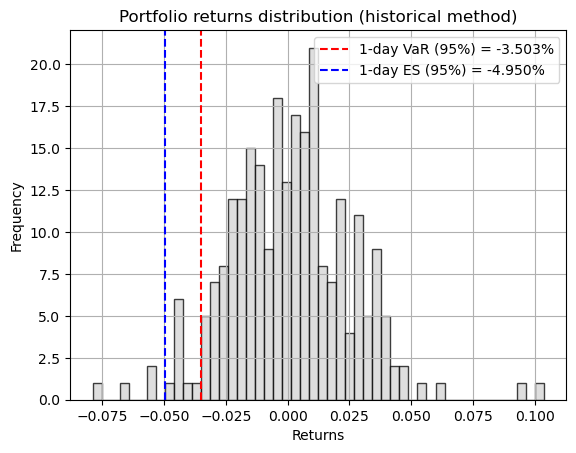

In [106]:
# plotting the portfolio historical returns along with VaR and ES
plt.hist(portfolio_hist_returns, bins = 50, alpha = 0.75, color = 'lightgray', edgecolor = 'black')
plt.axvline(VaR_hist, color = 'red', linestyle = '--', label = f"1-day VaR ({int(cl*100)}%) = {VaR_hist*100:.3f}%")
plt.axvline(ES_hist, color = 'blue', linestyle = '--', label = f"1-day ES ({int(cl*100)}%) = {ES_hist*100:.3f}%")
plt.title("Portfolio returns distribution (historical method)")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

A key assumption of the variance-covariance (parametric) method is that the portfolio returns are normally distributed. Calculations of VaR and ES are based on the mean, standard deviation, and correlation of the stock returns, using the following formulas.  
$VaR = \mu_P − Z_\alpha \cdot \sigma_P$, where $\mu_P$ is the expected portfolio return, $Z_\alpha$ is the z-score corresponding to the confidence level, and $\sigma_P$ is the portfolio standard deviation (volatility).  
$ES = \mu_P − \frac{\phi \left( Z_\alpha \right)}{\alpha - 1} \cdot \sigma_P$, where $\phi \left( Z_\alpha \right)$ is the probability density function value at the z-score and $\alpha$ is the confidence level.

In [108]:
# calculating the portfolio mean return and standard deviation (volatility)
portfolio_mean = np.dot(weights, mean_returns)   # weighted average of the individual stock returns
portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Z-score for the assumed confidence level
z_alpha = norm.ppf(cl)

# calculating Value at Risk (VaR)
VaR_param = portfolio_mean - z_alpha * portfolio_std

# calculating Expected Shortfall (ES)
ES_param = portfolio_mean - (norm.pdf(z_alpha) / pp) * portfolio_std

In [109]:
# printing the VaR and ES values
print(f"1-day VaR ({int(cl*100)}% confidence level) calculated using the parametric method is equal to {VaR_param*100:.3f}%.")
print(f"1-day ES ({int(cl*100)}% confidence level) calculated using the parametric method is equal to {ES_param*100:.3f}%.")

1-day VaR (95% confidence level) calculated using the parametric method is equal to -3.952%.
1-day ES (95% confidence level) calculated using the parametric method is equal to -4.981%.


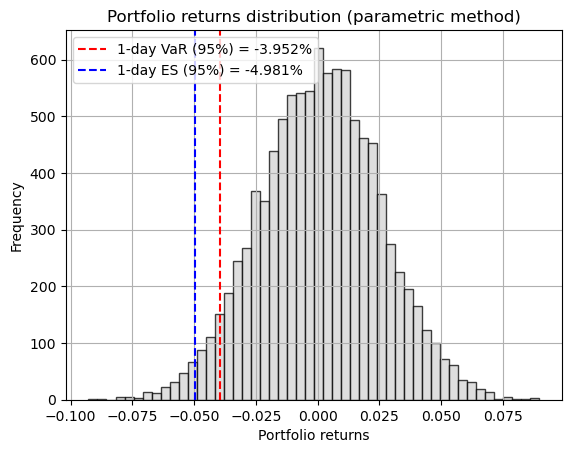

In [110]:
# plotting the portfolio returns distribution calculated out of a normal distribution, along with VaR and ES
simulated_returns = np.random.normal(portfolio_mean, portfolio_std, 10000)

plt.hist(simulated_returns, bins = 50, alpha = 0.75, color = 'lightgray', edgecolor = 'black')
plt.axvline(VaR_param, color = 'red', linestyle = '--', label = f"1-day VaR ({int(cl*100)}%) = {VaR_param*100:.3f}%")
plt.axvline(ES_param, color = 'blue', linestyle = '--', label = f"1-day ES ({int(cl*100)}%) = {ES_param*100:.3f}%")
plt.title("Portfolio returns distribution (parametric method)")
plt.xlabel("Portfolio returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

The Monte-Carlo method for computing VaR and ES involves a large number of simulations of the portfolio evolution. Each scenario corresponds to a potential future value of the portfolio considering asset prices, weights, and covariances. By simulating these scenarios, the distribution of the portfolio’s future returns is established. The percentile that corresponds to the desired confidence level leads to estimation of VaR and ES.

In [112]:
# number of Monte-Carlo simulations #####################################
M = 10000

In [113]:
# Cholesky decomposition of the covariance matrix
L = np.linalg.cholesky(cov_matrix)

# generating random returns for the assets using the Cholesky decomposition
random_returns = np.random.randn(M, 2)
correlated_returns = np.dot(random_returns, L.T)

# calculating portfolio returns
portfolio_returns = weights[0] * correlated_returns[:, 0] + weights[1] * correlated_returns[:, 1]

# calculating Value at Risk (VaR)
VaR_MC = np.percentile(portfolio_returns, 100 * pp)

# calculating Expected Shortfall (ES)
ES_MC = portfolio_returns[portfolio_returns <= VaR_MC].mean()

In [114]:
# printing the VaR and ES values
print(f"1-day VaR ({int(cl*100)}% confidence level) calculated using the Monte-Carlo simulations is equal to {VaR_MC*100:.3f}%.")
print(f"1-day ES ({int(cl*100)}% confidence level) calculated using the Monte-Carlo simulations is equal to {ES_MC*100:.3f}%.")

1-day VaR (95% confidence level) calculated using the Monte-Carlo simulations is equal to -4.051%.
1-day ES (95% confidence level) calculated using the Monte-Carlo simulations is equal to -5.096%.


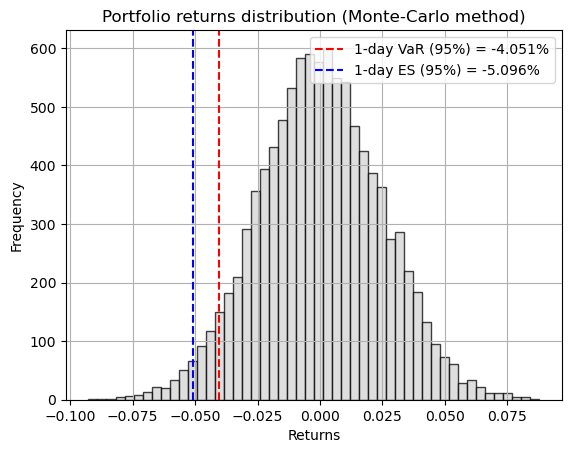

In [115]:
# plotting the portfolio returns distribution calculated with the Monte-Carlo method along with VaR and ES
plt.hist(portfolio_returns, bins = 50, alpha = 0.75, color = 'lightgray', edgecolor = 'black')
plt.axvline(VaR_MC, color = 'red', linestyle = '--', label = f"1-day VaR ({int(cl*100)}%) = {VaR_MC*100:.3f}%")
plt.axvline(ES_MC, color = 'blue', linestyle = '--', label = f"1-day ES ({int(cl*100)}%) = {ES_MC*100:.3f}%")
plt.title("Portfolio returns distribution (Monte-Carlo method)")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

---------------------------------

In [117]:
print(f"1-day VaR ({int(cl*100)}%) CALCULATION SUMMARY")

print(f"\n\
 the historical method: {round(VaR_hist*100, 3)}%\n\
 the variance-covariance (parametric) method: {round(VaR_param*100, 3)}%\n\
 the Monte-Carlo method: {round(VaR_MC*100, 3)}% \n")

print(f"1-day ES ({int(cl*100)}%) CALCULATION SUMMARY")

print(f"\n\
 the historical method: {round(ES_hist*100, 3)}%\n\
 the variance-covariance (parametric) method: {round(ES_param*100, 3)}%\n\
 the Monte-Carlo method: {round(ES_MC*100, 3)}%")

1-day VaR (95%) CALCULATION SUMMARY

 the historical method: -3.503%
 the variance-covariance (parametric) method: -3.952%
 the Monte-Carlo method: -4.051% 

1-day ES (95%) CALCULATION SUMMARY

 the historical method: -4.95%
 the variance-covariance (parametric) method: -4.981%
 the Monte-Carlo method: -5.096%


-------

### 10. Model validation of the value at risk calculations for a two-asset portfolio

Analysis of variance (ANOVA) is a statistical technique used to compare the amount of variation between group means to the amount of variation within each group to determine whether there are significant differences between the groups.

In [121]:
# creating a dataframe for ANOVA
var_results = pd.DataFrame({
    'VaR_method': ['Historical'] * len(portfolio_hist_returns) + 
                  ['Parametric'] * len(portfolio_hist_returns) + 
                  ['Monte-Carlo'] * len(portfolio_hist_returns),
    'VaR_value': np.concatenate([
        np.full(len(portfolio_hist_returns), VaR_hist),
        np.full(len(portfolio_hist_returns), VaR_param),
        np.full(len(portfolio_hist_returns), VaR_MC)
    ])
})

# performing one-way ANOVA
model = ols('VaR_value ~ C(VaR_method)', data = var_results).fit()
anova_table = sm.stats.anova_lm(model, typ = 2)

# printing results
print("\n ANOVA results: \n", anova_table)


 ANOVA results: 
                      sum_sq     df             F  PR(>F)
C(VaR_method)  4.248601e-03    2.0  3.094564e+29     0.0
Residual       5.107277e-30  744.0           NaN     NaN


The larger the F-statistic, $F = \frac{\textrm{variation between sample means}}{\textrm{variation within samples}}$, the greater the variation between sample means relative to the variation within the samples $\rightarrow$ there is a difference between the group means;  
the p-value, PR(>F), $< 1 - \textrm{confidence level}$ informs that the methods yield significantly different results $\rightarrow$ at least one method is statistically different from the others.

-------

The Kupiec proportion of failures (POF) backtesting test (unconditional coverage test) checks whether the number of VaR breaches (actual losses exceeding the predicted VaR) matches the expected failure rate, $< 1 - \textrm{confidence level}$;  
the Christoffersen conditional coverage (CC) backtesting test extends the Kupiec test by checking whether the VaR violations are independent (not clustering in certain periods).

In [125]:
# Kupiec's proportion of failures (POF) test
def kupiec_pof_test(actual_returns, VaR, pp):
    n = len(actual_returns)   # number of observations
    x = np.sum(actual_returns < VaR)   # number of violations
    p = pp   # expected failure probability

    likelihood_ratio = -2 * (np.log((1.0 - p) ** (n - x) * (p ** x)) - np.log((1.0 - x/n) ** (n - x) * (x/n) ** x))
    p_value = 1.0 - stats.chi2.cdf(likelihood_ratio, df = 1)

    return x, p_value

# Christoffersen's conditional coverage (CC) test
def christoffersen_cc_test(actual_returns, VaR):
    n00, n01, n10, n11 = 0, 0, 0, 0
    previous_violation = actual_returns.iloc[0] < VaR

    for i in range(1, len(actual_returns)):
        current_violation = actual_returns.iloc[i] < VaR
        if not previous_violation and not current_violation:
            n00 += 1
        elif not previous_violation and current_violation:
            n01 += 1
        elif previous_violation and not current_violation:
            n10 += 1
        elif previous_violation and current_violation:
            n11 += 1
        previous_violation = current_violation

    p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
    p11 = n11 / (n10 + n11) if (n10 + n11) > 0 else 0
    p1 = (n01 + n11) / (n00 + n01 + n10 + n11)

    if p1 in [0, 1]:
        return 'Indeterminate'

    likelihood_ratio = -2.0 * (np.log((1.0 - p1) ** (n00 + n10) * p1 ** (n01 + n11)) 
                               - np.log((1.0 - p01) ** n00 * p01 ** n01 * (1.0 - p11) ** n10 * p11 ** n11))
    p_value = 1.0 - stats.chi2.cdf(likelihood_ratio, df = 1)

    return p_value

# running tests for each VaR method
kupiec_hist = kupiec_pof_test(portfolio_hist_returns, VaR_hist, pp)
kupiec_param = kupiec_pof_test(portfolio_hist_returns, VaR_param, pp)
kupiec_mc = kupiec_pof_test(portfolio_hist_returns, VaR_MC, pp)

christoffersen_hist = christoffersen_cc_test(portfolio_hist_returns, VaR_hist)
christoffersen_param = christoffersen_cc_test(portfolio_hist_returns, VaR_param)
christoffersen_mc = christoffersen_cc_test(portfolio_hist_returns, VaR_MC)

In [126]:
# printing results
print("\n Kupiec's POF test results:")
print(f"Historical: violations = {kupiec_hist[0]}, p-value = {kupiec_hist[1]:.4f}")
print(f"Parametric: violations = {kupiec_param[0]}, p-value = {kupiec_param[1]:.4f}")
print(f"Monte-Carlo: violations = {kupiec_mc[0]}, p-value = {kupiec_mc[1]:.4f}")

print("\n Christoffersen's CC test results:")
print(f"Historical: p-value = {christoffersen_hist:.4f}")
print(f"Parametric: p-value = {christoffersen_param:.4f}")
print(f"Monte-Carlo: p-value = {christoffersen_mc:.4f}")


 Kupiec's POF test results:
Historical: violations = 13, p-value = 0.8738
Parametric: violations = 12, p-value = 0.8953
Monte-Carlo: violations = 12, p-value = 0.8953

 Christoffersen's CC test results:
Historical: p-value = 0.7014
Parametric: p-value = 0.5964
Monte-Carlo: p-value = 0.5964


If p-value $< 1 - \textrm{confidence level}$ in Kupiec test, the model fails the test (bad estimate) $\rightarrow$ test passed, neither model excluded.  
if p-value $< 1 - \textrm{confidence level}$ in Christoffersen, VaR violations are not independent (bad model) $\rightarrow$ violations independent.

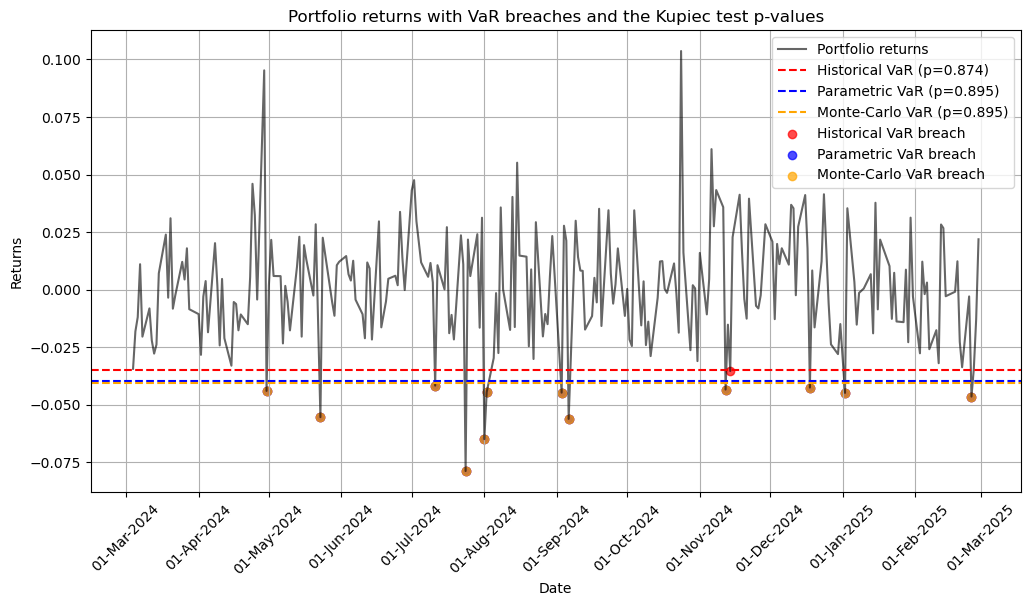

In [128]:
# visualization of results
portfolio_hist_returns_df = portfolio_hist_returns.to_frame()
portfolio_hist_returns_df['Date'] = portfolio['Date']

plt.figure(figsize = (12,6))

x = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in portfolio_hist_returns_df['Date']]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
#
plt.plot(x, portfolio_hist_returns_df.iloc[:,0], label = "Portfolio returns", color = 'black', alpha = 0.6)
plt.axhline(VaR_hist, color = 'red', linestyle = '--', label = f"Historical VaR (p={kupiec_hist[1]:.3f})")
plt.axhline(VaR_param, color = 'blue', linestyle = '--', label = f"Parametric VaR (p={kupiec_param[1]:.3f})")
plt.axhline(VaR_MC, color = 'orange', linestyle = '--', label = f"Monte-Carlo VaR (p={kupiec_mc[1]:.3f})")

# VaR violations
x1 = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in portfolio_hist_returns_df[portfolio_hist_returns_df.iloc[:,0] < VaR_hist]['Date']]
x2 = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in portfolio_hist_returns_df[portfolio_hist_returns_df.iloc[:,0] < VaR_param]['Date']]
x3 = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in portfolio_hist_returns_df[portfolio_hist_returns_df.iloc[:,0] < VaR_MC]['Date']]
#
plt.scatter(x1, portfolio_hist_returns_df[portfolio_hist_returns_df.iloc[:,0] < VaR_hist].iloc[:,0],
            color = 'red', label = "Historical VaR breach", alpha = 0.7)
plt.scatter(x2, portfolio_hist_returns_df[portfolio_hist_returns_df.iloc[:,0] < VaR_param].iloc[:,0],
            color = 'blue', label = "Parametric VaR breach", alpha = 0.7)
plt.scatter(x3, portfolio_hist_returns_df[portfolio_hist_returns_df.iloc[:,0] < VaR_MC].iloc[:,0],
            color = 'orange', label = "Monte-Carlo VaR breach", alpha = 0.7)

plt.title("Portfolio returns with VaR breaches and the Kupiec test p-values")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend()
plt.xticks(rotation = 45)
plt.grid(True)
plt.show()

-------

ES accuracy ratio is a ratio between the calculated ES and an average of empirical excess losses. It can be used for the VaR models validation, as ES is a more sensitive risk measure.

In [131]:
# calculating ES accuracy ratio
def ES_acc_ratio(returns, var_value, es_value, confidence_level):
    returns = np.array(returns)
    var_value = np.array(var_value)
    es_value = np.array(es_value)
    
    # identifying VaR breaches
    breaches = returns < -var_value  # true where returns are worse than VaR
    num_breaches = np.sum(breaches)

    if num_breaches > 0:
        # computing empirical ES (average loss beyond VaR)
        empirical_es = -np.mean(returns[breaches])
    else:
        empirical_es = 0   # no breaches mean no tail losses

    # computing ES accuracy ratio
    es_model_avg = np.mean(es_value[breaches]) if num_breaches > 0 else 0
    es_accuracy_ratio = empirical_es / es_model_avg if es_model_avg > 0 else np.nan

    return -empirical_es, es_accuracy_ratio

In [132]:
var_estimate = VaR_hist
es_estimate = ES_hist
# converting to arrays for consistency
var_value = np.full(len(portfolio_hist_returns), -var_estimate)   # negative because losses are positive
es_value = np.full(len(portfolio_hist_returns), -es_estimate)
#
ES_emp_hist, ES_ar_hist = ES_acc_ratio(portfolio_hist_returns, var_value, es_value, cl)

var_estimate = VaR_param
es_estimate = ES_param
var_value = np.full(len(portfolio_hist_returns), -var_estimate)
es_value = np.full(len(portfolio_hist_returns), -es_estimate)
#
ES_emp_param, ES_ar_param = ES_acc_ratio(portfolio_hist_returns, var_value, es_value, cl)

var_estimate = VaR_MC
es_estimate = ES_MC
var_value = np.full(len(portfolio_hist_returns), -var_estimate)
es_value = np.full(len(portfolio_hist_returns), -es_estimate)
#
ES_emp_MC, ES_ar_MC = ES_acc_ratio(portfolio_hist_returns, var_value, es_value, cl)

In [133]:
# printing results
print("\n VaR model validation via ES calculations:")
print(f"Historical: empirical ES = {ES_emp_hist*100:.3f}%, ES accuracy ratio = {ES_ar_hist:.5f}")
print(f"Parametric: empirical ES = {ES_emp_param*100:.3f}%, ES accuracy ratio = {ES_ar_param:.5f}")
print(f"Monte-Carlo: empirical ES = {ES_emp_MC*100:.3f}%, ES accuracy ratio = {ES_ar_MC:.5f}")


 VaR model validation via ES calculations:
Historical: empirical ES = -4.950%, ES accuracy ratio = 1.00000
Parametric: empirical ES = -5.068%, ES accuracy ratio = 1.01755
Monte-Carlo: empirical ES = -5.068%, ES accuracy ratio = 0.99448


If the ES accuracy ratio differs significantly from 1, the model underestimates risk $\rightarrow$ satisfactory estimates.

-------

Stress testing accounts for checking model robustness under extreme conditions by simulating hypothetical worst-case scenarios for a market parameter. After applying the shock to market data, calculations are performed again and the outcomes are compared to the original ones.

In [137]:
shock_factor = -0.25   # percentage drop in all assets values, converted to decimal #####################################
shock_duration = 4     # length of shock in days #####################################

In [138]:
# creating dataframe of dates and shock applied to stock data at the beginning of Dec-2024
shock_dict = {'Date': stockdata['Date'], 'Shock': 1.0}
shock = pd.DataFrame(shock_dict)

for i in range(shock_duration-1):
    shock.loc[192+i, 'Shock'] = shock.loc[192+i, 'Shock'] + (i + 1) / shock_duration * shock_factor

shock.loc[195:, 'Shock'] += shock.loc[195:, 'Shock'].apply(lambda x: x * shock_factor)

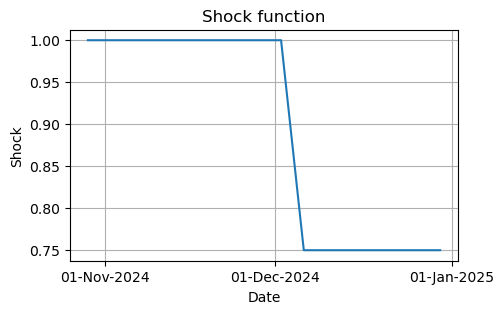

In [139]:
# plotting the shock function
plt.figure(figsize = (5,3))
plt.title("Shock function")
plt.xlabel("Date")
plt.ylabel("Shock")

x = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in stockdata['Date']]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.plot(x[167:210], shock.loc[168:210, 'Shock'])

plt.grid(True)

In [140]:
portfolio_shocked = portfolio[['TSLA', 'BA']]
portfolio_shocked = portfolio_shocked.apply(lambda x: x * shock['Shock'])

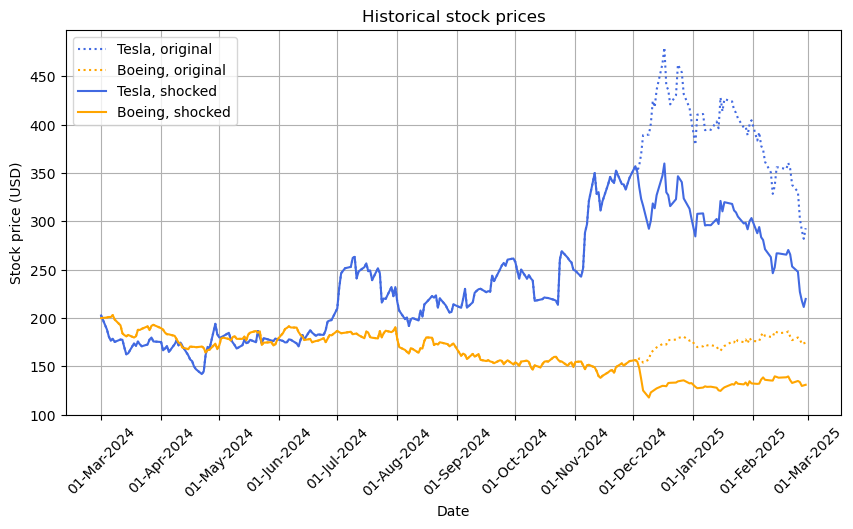

In [141]:
# plotting the Tesla & Boeing stock prices without and with shock applied
plt.figure(figsize = (10,5))
plt.title("Historical stock prices")
plt.xlabel("Date")
plt.ylabel("Stock price (USD)")

x = [dt.datetime.strptime(d, '%d/%m/%Y').date() for d in stockdata['Date']]
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.plot(x, stockdata['Close'], color = 'royalblue', linestyle = 'dotted', label = "Tesla, original")
plt.plot(x, stockdata_BA['Close'], color = 'orange', linestyle = 'dotted', label = "Boeing, original")
plt.plot(x, portfolio_shocked['TSLA'], color = 'royalblue', label = "Tesla, shocked")
plt.plot(x, portfolio_shocked['BA'], color = 'orange', label = "Boeing, shocked")

plt.legend()
plt.xticks(rotation = 45)
plt.grid(True)

In [142]:
# calculating historical daily returns for each stock
returns_shocked = portfolio_shocked[['TSLA', 'BA']].pct_change().dropna()

# calculating mean and standard deviation for each stock's historical returns
mean_returns_shocked = returns_shocked.mean()
std_returns_shocked = returns_shocked.std()

# calculating the covariance matrix for the returns
cov_matrix_shocked = returns_shocked.cov()

1-day VaR (95% confidence level) with shock applied calculated using the parametric method is equal to -4.372%.
1-day ES (95% confidence level) with shock applied calculated using the parametric method is equal to -5.091%.


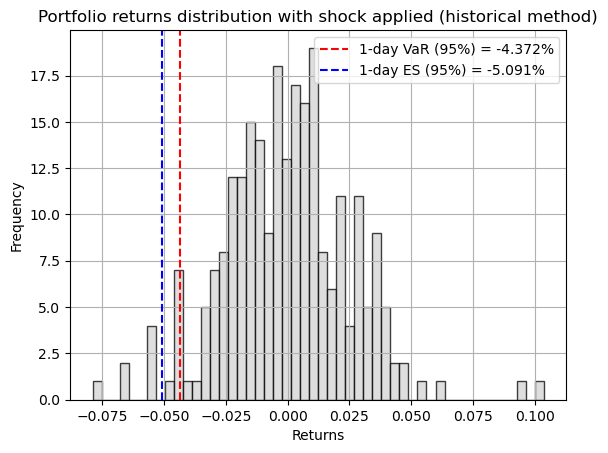

In [143]:
# calculating historical returns of the portfolio, scaled to the time horizon
portfolio_hist_returns_shocked = returns_shocked.dot(weights)

# calculating Value at Risk (VaR)
VaR_hist_shocked = np.percentile(portfolio_hist_returns_shocked, 100 * pp)

# calculating Expected Shortfall (ES)
ES_hist_shocked = portfolio_hist_returns_shocked[portfolio_hist_returns_shocked <= VaR_hist].mean()

# printing the VaR and ES values
print(f"1-day VaR ({int(cl*100)}% confidence level) with shock applied calculated using the parametric method is equal to {VaR_hist_shocked*100:.3f}%.")
print(f"1-day ES ({int(cl*100)}% confidence level) with shock applied calculated using the parametric method is equal to {ES_hist_shocked*100:.3f}%.")

# plotting the portfolio historical returns along with VaR and ES
plt.hist(portfolio_hist_returns_shocked, bins = 50, alpha = 0.75, color = 'lightgray', edgecolor = 'black')
plt.axvline(VaR_hist_shocked, color = 'red', linestyle = '--', label = f"1-day VaR ({int(cl*100)}%) = {VaR_hist_shocked*100:.3f}%")
plt.axvline(ES_hist_shocked, color = 'blue', linestyle = '--', label = f"1-day ES ({int(cl*100)}%) = {ES_hist_shocked*100:.3f}%")
plt.title("Portfolio returns distribution with shock applied (historical method)")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

1-day VaR (95% confidence level) with shock applied calculated using the parametric method is equal to -4.221%.
1-day ES (95% confidence level) with shock applied calculated using the parametric method is equal to -5.290%.


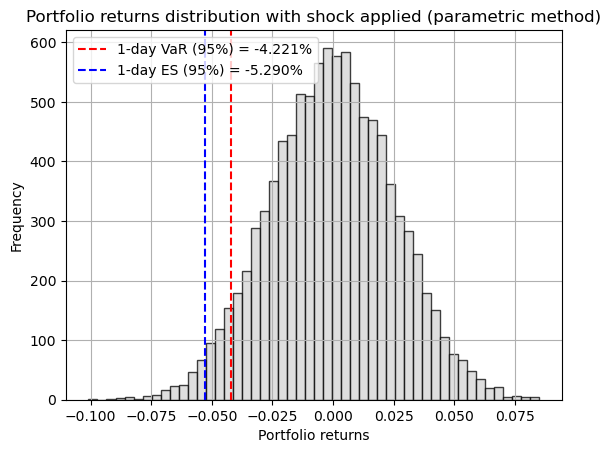

In [144]:
# calculating the portfolio mean return and standard deviation (volatility)
portfolio_mean_shocked = np.dot(weights, mean_returns_shocked)   # weighted average of the individual stock returns
portfolio_std_shocked = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_shocked, weights)))

# Z-score for the assumed confidence level
z_alpha = norm.ppf(cl)

# calculating Value at Risk (VaR)
VaR_param_shocked = portfolio_mean_shocked - z_alpha * portfolio_std_shocked

# calculating Expected Shortfall (ES)
ES_param_shocked = portfolio_mean_shocked - (norm.pdf(z_alpha) / pp) * portfolio_std_shocked

# printing the VaR and ES values
print(f"1-day VaR ({int(cl*100)}% confidence level) with shock applied calculated using the parametric method is equal to {VaR_param_shocked*100:.3f}%.")
print(f"1-day ES ({int(cl*100)}% confidence level) with shock applied calculated using the parametric method is equal to {ES_param_shocked*100:.3f}%.")

# plotting the portfolio returns distribution calculated out of a normal distribution, along with VaR and ES
simulated_returns_shocked = np.random.normal(portfolio_mean_shocked, portfolio_std_shocked, 10000)

plt.hist(simulated_returns_shocked, bins = 50, alpha = 0.75, color = 'lightgray', edgecolor = 'black')
plt.axvline(VaR_param_shocked, color = 'red', linestyle = '--', label = f"1-day VaR ({int(cl*100)}%) = {VaR_param_shocked*100:.3f}%")
plt.axvline(ES_param_shocked, color = 'blue', linestyle = '--', label = f"1-day ES ({int(cl*100)}%) = {ES_param_shocked*100:.3f}%")
plt.title("Portfolio returns distribution with shock applied (parametric method)")
plt.xlabel("Portfolio returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

1-day VaR (95% confidence level) with shock applied calculated using the Monte-Carlo simulations is equal to -4.231%.
1-day ES (95% confidence level) with shock applied calculated using the Monte-Carlo simulations is equal to -5.123%.


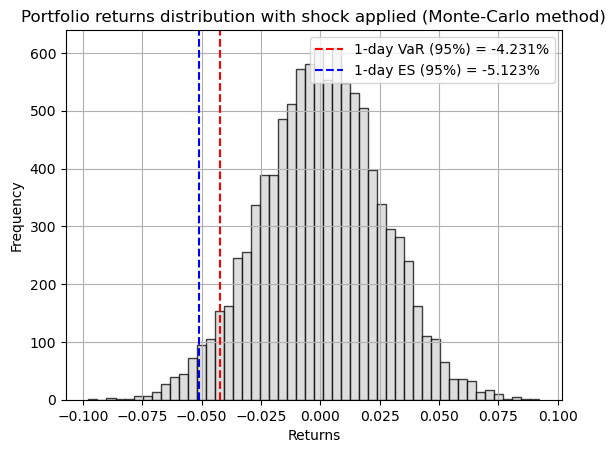

In [145]:
# Cholesky decomposition of the covariance matrix
L = np.linalg.cholesky(cov_matrix_shocked)

# generating random returns for the assets using the Cholesky decomposition
random_returns = np.random.randn(M, 2)
correlated_returns_shocked = np.dot(random_returns, L.T)

# calculating portfolio returns
portfolio_returns_shocked = weights[0] * correlated_returns_shocked[:,0] + weights[1] * correlated_returns_shocked[:,1]

# calculating Value at Risk (VaR)
VaR_MC_shocked = np.percentile(portfolio_returns_shocked, 100 * pp)

# calculating Expected Shortfall (ES)
ES_MC_shocked = portfolio_returns_shocked[portfolio_returns_shocked <= VaR_MC].mean()

# printing the VaR and ES values
print(f"1-day VaR ({int(cl*100)}% confidence level) with shock applied calculated using the Monte-Carlo simulations "
      f"is equal to {VaR_MC_shocked*100:.3f}%.")
print(f"1-day ES ({int(cl*100)}% confidence level) with shock applied calculated using the Monte-Carlo simulations is equal to {ES_MC_shocked*100:.3f}%.")

# plotting the portfolio returns distribution calculated with the Monte-Carlo method along with VaR and ES
plt.hist(portfolio_returns_shocked, bins = 50, alpha = 0.75, color = 'lightgray', edgecolor = 'black')
plt.axvline(VaR_MC_shocked, color = 'red', linestyle = '--', label = f"1-day VaR ({int(cl*100)}%) = {VaR_MC_shocked*100:.3f}%")
plt.axvline(ES_MC_shocked, color = 'blue', linestyle = '--', label = f"1-day ES ({int(cl*100)}%) = {ES_MC_shocked*100:.3f}%")
plt.title("Portfolio returns distribution with shock applied (Monte-Carlo method)")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [146]:
# printing results
print(f"1-day VaR and ES ({int(cl*100)}%) WITH SHOCK APPLIED CALCULATION SUMMARY")
methods_list = ["METHOD", "historical", "parametric", "Monte-Carlo"]

VaRs_list = ["VaR", f"{round(VaR_hist*100, 3)}%", f"{round(VaR_param*100, 3)}%", f"{round(VaR_MC*100, 3)}%"]
VaRs_shocked_list = ["VaR with shock", f"{round(VaR_hist_shocked*100, 3)}%", f"{round(VaR_param_shocked*100, 3)}%", f"{round(VaR_MC_shocked*100, 3)}%"]
VaRs_change_list = ["Increase in VaR", f"{round(abs((VaR_hist - VaR_hist_shocked) / VaR_hist)*100, 3)}%", 
                    f"{round(abs((VaR_param - VaR_param_shocked) / VaR_param)*100, 3)}%", f"{round(abs((VaR_MC - VaR_MC_shocked) / VaR_MC)*100, 3)}%"]
d = [methods_list, VaRs_list, VaRs_shocked_list, VaRs_change_list]
print(tabulate(d, tablefmt = 'grid'))

ESs_list = ["ES", f"{round(ES_hist*100, 3)}%", f"{round(ES_param*100, 3)}%", f"{round(ES_MC*100, 3)}%"]
ESs_shocked_list = ["ES with shock", f"{round(ES_hist_shocked*100, 3)}%", f"{round(ES_param_shocked*100, 3)}%", f"{round(ES_MC_shocked*100, 3)}%"]
ESs_change_list = ["Increase in ES", f"{round(abs((ES_hist - ES_hist_shocked) / ES_hist)*100, 3)}%", 
                   f"{round(abs((ES_param - ES_param_shocked) / ES_param)*100, 3)}%", f"{round(abs((ES_MC - ES_MC_shocked) / ES_MC)*100, 3)}%"]
d = [methods_list, ESs_list, ESs_shocked_list, ESs_change_list]
print(tabulate(d, tablefmt = 'grid'))

1-day VaR and ES (95%) WITH SHOCK APPLIED CALCULATION SUMMARY
+-----------------+------------+------------+-------------+
| METHOD          | historical | parametric | Monte-Carlo |
+-----------------+------------+------------+-------------+
| VaR             | -3.503%    | -3.952%    | -4.051%     |
+-----------------+------------+------------+-------------+
| VaR with shock  | -4.372%    | -4.221%    | -4.231%     |
+-----------------+------------+------------+-------------+
| Increase in VaR | 24.801%    | 6.826%     | 4.423%      |
+-----------------+------------+------------+-------------+
+----------------+------------+------------+-------------+
| METHOD         | historical | parametric | Monte-Carlo |
+----------------+------------+------------+-------------+
| ES             | -4.95%     | -4.981%    | -5.096%     |
+----------------+------------+------------+-------------+
| ES with shock  | -5.091%    | -5.29%     | -5.123%     |
+----------------+------------+------------+

VaR and ES increase after the shock $\rightarrow$ appropriate response to increased volatility;  
VaR and ES losses are not substantial, VaR rises more than ES despite the market shock $\rightarrow$ the models might underestimate tail risk.

###### Anna Nakonieczna, Mar 2025